# talking data- cellphone user demographics prediction

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/5340/media/TalkingData_banner-265x200.png">



# Introduction
Customer demographics profile has many applications. It can identify key characteristics of the customer, so that we can refine marketing strategy and increase engagement.

A more tangible example of such application can be found in recommendation system. For instance, a brief EDA indicates that users in 32-40 and 44+ age group are more active than users in younger age group. Note that users in different age group would have different interests in, say, news and/or music. So, based on the demographics prediction, as well as the demographics behavior and interests profiles. A recommendation system can provide semi-customized ('semi-customized' meaning based on group segmentation profiles) information at 'right' time for the 'right' people.

In this notebook, I will demonstrate a typical machine learning pipe line to tackle this classification problem, from EDA, data preprocessing, model training and evaluation. 



# A little bit more about the data
Before we jump into the code, let me give you a brief preview of the data. 
The dataset is a relational database consist of 5 relevant dataframes, in which describe:
- targets: gender, age_group, age, associated with device_id
- device types: cell phone brands (e.g., Samsung), cell phone models (e.g. Galaxy5) (note: an assumption is one device_id is only associated with one user)
- events: timestamp (that users used the phones), GPS coordinates
- app_ids: the app ids users used(associated with the events)
- app_categories: app categories users used (e.g., game, financial) associated with the app_ids

Since this is a relational dataframe, I 've done some data cleaning and data wrangling work to 
- first merge the 5 dataframes into 1 cross-table based on the dataframe relationships. (note: in this merged cross-table, one device_id can appear in multiple rows.)
- then, extract features and creat to make sure one device_id only has one record.

Note: In this notebook, I am presenting the pipeline using the merged-and-feature-extracted cross-table. For more information and the walk-through from the original 5 dataframes, please refer to my another notebook.[**LINK HERE**](https://github.com/kefeimo/Thinkful_DataScience/blob/master/module38%20final%20capstone/final_capstone_PART_I_eda.ipynb)

**the relational database**
<img src="https://github.com/kefeimo/Thinkful_DataScience/raw/master/module38%20final%20capstone/res/thinkful%20talking%20data.png">




# Table of Content
## EDA
- EDA on the targets: gender, age_group, age
- EDA on the features (against targets): GPS coordinates, hours, app_category, app_id, phone_brand, phone_model

## Model preparation
- train-test split
- feature engineering (selectKbest, scaling, PCA)

## ML training 
- model choice
- training and evaulation
- model fine-tune
- Deep learning
- multi-class task
- regression task

## Lesson learned and feature works

# Data preview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
RANDOM_STATE = 2020

In [3]:
# on colab
from google.colab import drive
drive.mount('/content/gdrive')
DIR_CURRENT = '/content/gdrive/My Drive/thinkful/assignment/Module38 final capstone'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# a peak of the data
df_work_on = pd.read_pickle(DIR_CURRENT+ '/data/df_work_on.pkl')
df_work_on.head()

,device_id,gender,age,group,age_cate,lat_mean,lat_std,lat_median,long_mean,long_std,long_median,event_count,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,label__-1,label__128,label__130,label__152,...,br_model_Samsung-Galaxy S6 Edge,br_model_Samsung-Galaxy S6 Edge+,br_model_TV Plus-Super phone 1,br_model_TV Plus-Super phone 1 Pro,br_model_TV Plus-Super phone 1s,br_model_Xiaomi-MI 2,br_model_Xiaomi-MI 2A,br_model_Xiaomi-MI 2S,br_model_Xiaomi-MI 3,br_model_Xiaomi-MI 4,br_model_Xiaomi-Millet 4C,br_model_Xiaomi-Millet note,br_model_Xiaomi-Red Rice 2,br_model_Xiaomi-Red rice,br_model_Xiaomi-Red rice 1S,br_model_Xiaomi-Red rice 2A,br_model_Xiaomi-Red rice Note2,br_model_Xiaomi-Red rice Note3,br_model_Xiaomi-Red rice note,br_model_Xiaomi-Red rice note enhanced version,br_model_Xiaomi-note top version,br_model_hammer-Nuts phone,br_model_hammer-T1,br_model_other_model,br_model_top150model,br_model_top200model,br_model_top250model,br_model_vivo-X3L,br_model_vivo-X5L,br_model_vivo-X5M,br_model_vivo-X5Max+,br_model_vivo-X5Pro,br_model_vivo-X5SL,br_model_vivo-X6 D,br_model_vivo-Xplay3S,br_model_vivo-Y23L,br_model_vivo-Y27,enc_by_device_4_event_id,enc_by_device_4_app_id,enc_by_device_4_label_id
0,-9.222957e+18,M,36.0,M32-38,A32-40,18.552000,9.348188,23.19,90.592000,45.648503,113.24,65.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.030769,0.000000,0.000000,0.000000,0.107692,0.200000,0.046154,0.076923,0.338462,0.000000,0.000000,0.000000,0.000000,0.061538,0.092308,0.000000,0.046154,0.028571,0.000000,0.0,0.028571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65,73,57
1,-9.221026e+18,F,31.0,F29-32,A29-31,27.721361,9.376818,30.87,102.692721,34.736061,114.36,147.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.047619,0.292517,0.068027,0.034014,0.040816,0.006803,0.020408,0.027211,0.000000,0.027211,0.088435,0.013605,0.027211,0.020408,0.176871,0.000000,0.088435,0.020408,0.028571,0.028571,0.0,0.028571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,147,39,62
2,-9.220831e+18,M,19.0,M22-,A22-,0.000000,0.000000,0.00,0.000000,0.000000,0.00,8.0,0.0,0.0,0.25,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.375000,0.125000,0.000000,0.250000,0.090909,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,13,24
3,-9.220062e+18,M,40.0,M39+,A40+,34.964231,20.383561,46.60,93.666346,54.605899,124.88,52.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.076923,0.019231,0.038462,0.000000,0.019231,0.153846,0.038462,0.346154,0.096154,0.000000,0.019231,0.019231,0.076923,0.038462,0.019231,0.038462,0.000000,0.000000,0.023810,0.023810,0.0,0.023810,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52,85,122
4,-9.218961e+18,F,53.0,F43+,A40+,0.000000,0.000000,0.00,0.000000,0.000000,0.00,6.0,0.0,0.0,0.00,0.0,0.0,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.027778,0.027778,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,30,59


In [5]:
df_work_on.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23290 entries, 0 to 23289
Columns: 235 entries, device_id to enc_by_device_4_label_id
dtypes: float64(229), int64(3), object(3)
memory usage: 41.8+ MB


In [6]:
# create a new column called 'age_cate' 
# (used to demonstrate the multi-class classification)
# (The orginal has 12-class labels is a bit too many for our demonstration)
df_matching =pd.DataFrame({'age_cate':df_work_on.age_cate.unique()})
df_matching['age_cate_new'] = ['A32+', 'A27-31', 'A26-', 'A32+', 'A26-','A27-31']
# df_matching
df_work_on = pd.merge(df_work_on,df_matching,
                             on='age_cate')

In [7]:
df_original = df_work_on.copy()

In [8]:
# a display of columns
# columns
col_key = ['device_id']
# df_original.columns[1:5]
col_target = ['gender', 'age', 'group','age_cate', 'age_cate_new']
# df_original.columns[5:11]
col_gps = ['lat_mean', 'lat_std', 'lat_median', 'long_mean', 'long_std',
       'long_median']
# df_original.columns[11:12]
col_event_count = ['event_count']
# df_original.columns[12:12+24]
col_hour = ['hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']
# df_original.columns[36:36+51]
col_label = ['label__-1', 'label__128', 'label__130', 'label__152', 'label__168',
       'label__179', 'label__209', 'label__251', 'label__252', 'label__256',
       'label__262', 'label__263', 'label__302', 'label__303', 'label__306',
       'label__405', 'label__548', 'label__549', 'label__564', 'label__704',
       'label__710', 'label__713', 'label__714', 'label__719', 'label__721',
       'label__730', 'label__751', 'label__756', 'label__757', 'label__761',
       'label__774', 'label__775', 'label__777', 'label__778', 'label__779',
       'label__781', 'label__782', 'label__783', 'label__786', 'label__787',
       'label__794', 'label__795', 'label__854', 'label__909', 'label__932',
       'label__959', 'label__960', 'label__1007', 'label__1012', 'label__1014',
       'label__1015']
# df_original.columns[87:87+20]
col_app = ['app__-6590029937880196169', 'app__-5720078949152207372',
       'app__-3955212733485100109', 'app__-2320783822570582843',
       'app__-538061441862183033', 'app__33792862810792679',
       'app__628020936226491308', 'app__3433289601737013244',
       'app__3683147815759994238', 'app__3717049149426646122',
       'app__4244331088397413857', 'app__4348659952760821294',
       'app__5729517255058371973', 'app__5927333115845830913',
       'app__6284164581582112235', 'app__7348340405200054701',
       'app__7460082553072507347', 'app__8693964245073640147',
       'app__8948670408023620661', 'app__9112463114311278255']
# df_original.columns[107:107+21]
col_brand = ['brand_A plus', 'brand_China Mobile', 'brand_Gionee', 'brand_HTC',
       'brand_Huawei', 'brand_Kupai', 'brand_LG', 'brand_Lenovo',
       'brand_Meizu', 'brand_Nubia', 'brand_OPPO', 'brand_Qiku',
       'brand_Samsung', 'brand_Sony', 'brand_TCL', 'brand_TV Plus',
       'brand_Xiaomi', 'brand_ZTE', 'brand_hammer', 'brand_other',
       'brand_vivo']
# df_original.columns[128:128+104]
col_br_model = list(df_original.columns[128:-3])

# inner encode
col_encode = ['enc_by_device_4_event_id',
       'enc_by_device_4_app_id', 'enc_by_device_4_label_id']

**Comments:**

As mentioned earlier, I am demonstrating the pipeline on the "half-way-done" cross table. In my another notebook you will find more details about data cleaning and preprocessing, including
- fill na (or drop na)
- merge relational tables
- text preprocessing (e.g., translation)
- feature extration (e.g., select Kbest, term frequency-selection)



# EDA
let's start EDA on this "half-way-done" dataset.
- (nested) target EDA (balance check)
- then, features against target (gender, age_cate, maybe age): gps, count, hour, app_label, app_cate, device_brand, device_br_model

## EDA: targets

In [9]:
# first set order for categorical target
from pandas.api.types import CategoricalDtype
df_original['age_cate_new'] = df_original.age_cate_new.astype(CategoricalDtype(
    categories=['A26-','A27-31','A32+'], ordered=True))
df_original['gender'] = df_original.gender.astype(
    CategoricalDtype(categories=['M', 'F'], ordered=True))

M F ratio: 1.897126508272173


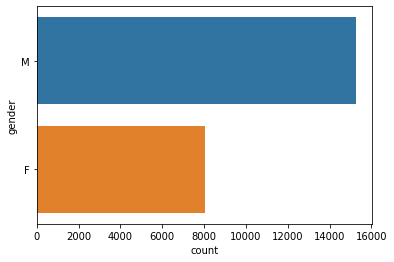

In [10]:
### target distribution
sns.countplot(data=df_work_on, y='gender')
print('M F ratio:', df_work_on.gender.value_counts()[0]/df_work_on.gender.value_counts()[1])

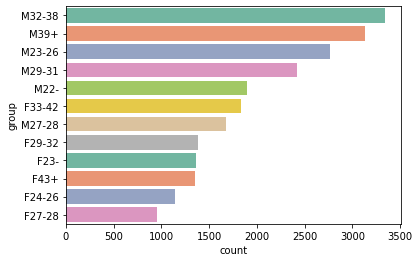

In [11]:
# I just hate this target (too many, no order)
order_tmp = df_original.group.value_counts().index
sns.countplot(data=df_original, y='group', palette='Set2', order=order_tmp)

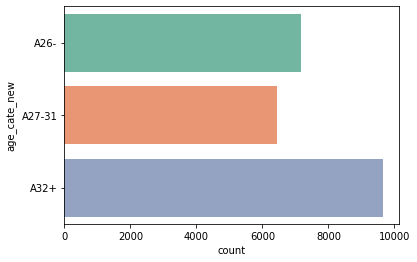

In [12]:
sns.countplot(data=df_original, y='age_cate_new', palette='Set2',)

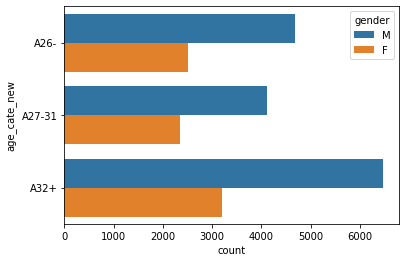

In [13]:
sns.countplot(data=df_original, y='age_cate_new', hue='gender',)

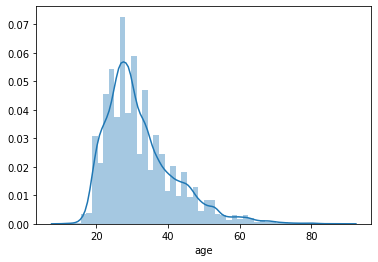

In [14]:
# last but not least, age target (regression task vs. classification task)
sns.distplot(df_original.age)

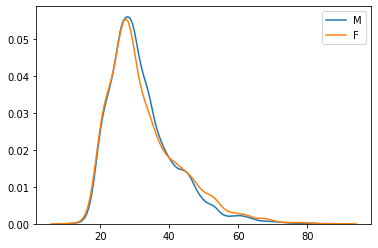

In [15]:
sns.kdeplot(df_original[df_original.gender=='M'].age, label='M')
sns.kdeplot(df_original[df_original.gender=='F'].age, label='F')

**Comments:**

- The gender class is somewhat imbalanced (with M:F ratio =1.8). 
- In the orignal "age_group" target, the "M32-38" has most users, while "F27-28" has least users.
- In the new created "age_cate_new" target, the "A32+" has the most users. 
- Also, in each age_cate_new class, the gender proportion is most likely consistant, with female users are less than the male ones.
- When looking at the age target, the central tendercy appears near 30-, for both male and female users.

## EDA: GPS features
- The GPS coords, e.g. latitude, longitude, are orginally associated with event_id. Since each device_id could have multiple event_id, thus multiple GPS coords.
- In the 'half-way-done' dataframe, I used descriptive statistics for GPS coords feature extraction. e.g., mean, median, std
- Here I visualized median GPS info.


In [16]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip
  Created wheel for basemap: filename=basemap-1.2.1-cp36-cp36m-linux_x86_64.whl size=121756173 sha256=6bfe43a0075033f015c9d1f261c1e60f97ca823cf0a7b07d83eb77b878025ca7
  Stored in directory: /tmp/pip-ephem-wheel-cache-wup2jlx9/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap


In [17]:
from mpl_toolkits.basemap import Basemap

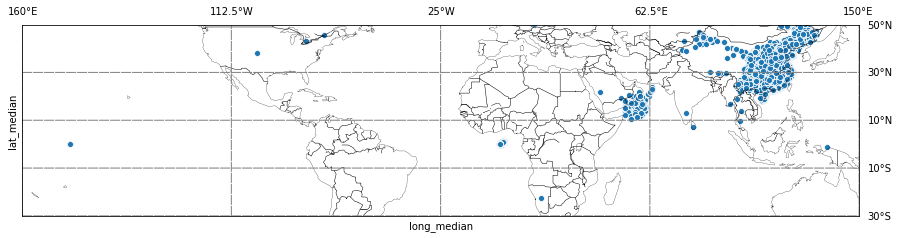

In [18]:
# don't be fooled by those gps at Africa, those are noises generated from zero gps
fig, ax = plt.subplots(1, 1, figsize=(15,15))

sns.scatterplot(data=df_original,
               x='long_median', y='lat_median',
               ax=ax)

# Initialize the map
map = Basemap(llcrnrlon=ax.get_xlim()[0]//10*10, urcrnrlon=ax.get_xlim()[1]//10*10,
              llcrnrlat=ax.get_ylim()[0]//10*10, urcrnrlat=ax.get_ylim()[1]//10*10, )
 
# Continent and countries!
# map.drawmapboundary(fill_color='#A6CAE0', ax=ax)
# map.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF', ax=ax)
map.drawcountries(color="black", linewidth=0.5, ax=ax)
map.drawcoastlines(color="black", linewidth=0.25, ax=ax)

meridians = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],5)
map.drawmeridians(meridians,
                  labels=[0,0,1,0], dashes=[10,1], color='gray'
                 )
parallels = np.linspace(ax.get_ylim()[0],ax.get_ylim()[1],5)
map.drawparallels(parallels,
                  labels=[0,1,1,0], 
                  dashes=[10,1], color='gray'
                 )

ax.set_aspect(aspect='equal')


plt.show()

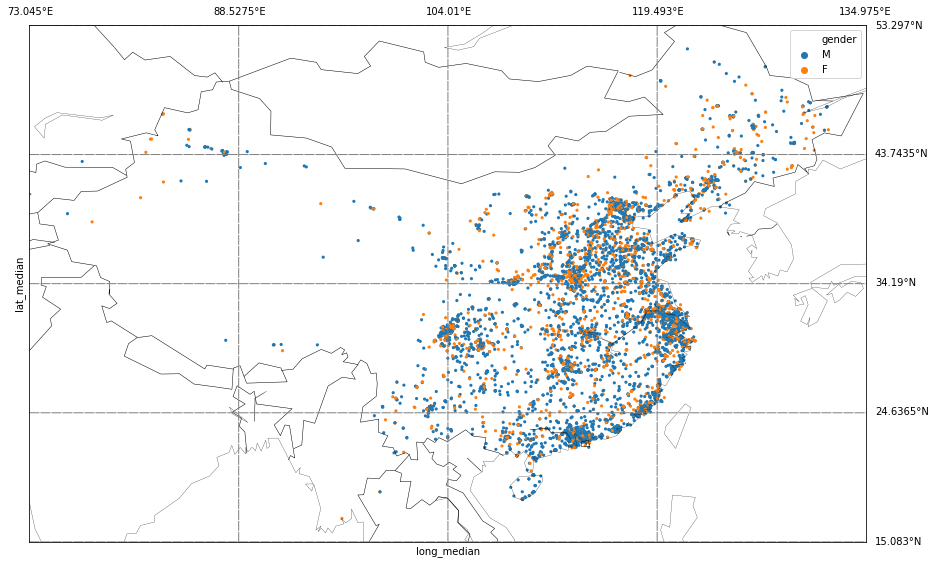

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

condition_tmp = (df_original.long_median>70) & (df_original.lat_median>15)
sns.scatterplot(data=df_original[condition_tmp],
               x='long_median', y='lat_median',
                hue='gender',
                s=10,
                edgecolor ='none',
               ax=ax)

# Initialize the map
map = Basemap(llcrnrlon=ax.get_xlim()[0], urcrnrlon=ax.get_xlim()[1],
              llcrnrlat=ax.get_ylim()[0], urcrnrlat=ax.get_ylim()[1], )
 
# Continent and countries!
# map.drawmapboundary(fill_color='#A6CAE0', ax=ax)
# map.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF', ax=ax)
map.drawcountries(color="black", linewidth=0.5, ax=ax)
map.drawcoastlines(color="black", linewidth=0.25, ax=ax)

meridians = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],5)
map.drawmeridians(meridians,
                  labels=[0,0,1,0], dashes=[10,1], color='gray'
                 )
parallels = np.linspace(ax.get_ylim()[0],ax.get_ylim()[1],5)
map.drawparallels(parallels,
                  labels=[0,1,1,0], 
                  dashes=[10,1], color='gray'
                 )

ax.set_aspect(aspect='equal')


plt.show()

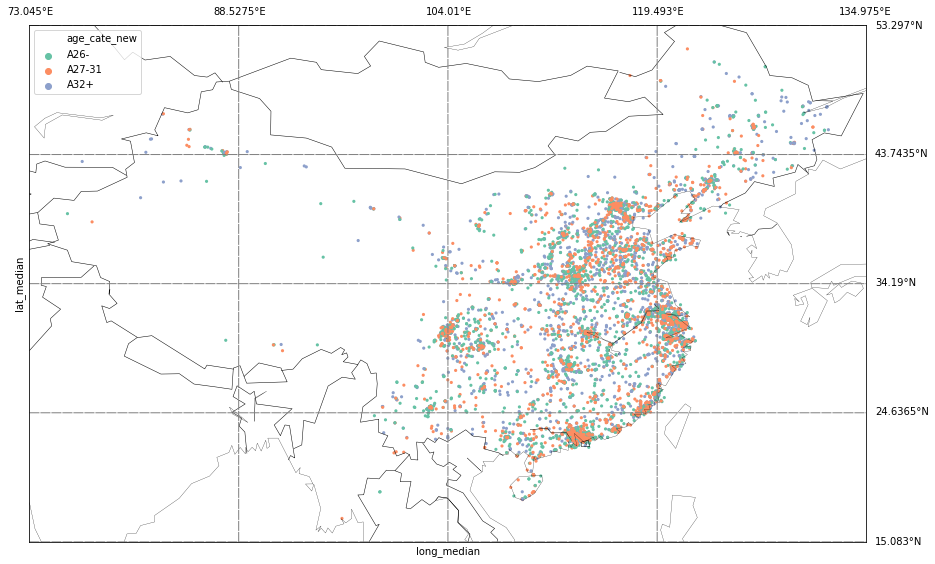

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

condition_tmp = (df_original.long_median>70) & (df_original.lat_median>15)
sns.scatterplot(data=df_original[condition_tmp],
               x='long_median', y='lat_median',
                hue='age_cate_new',
                s=10,
                edgecolor ='none',
                palette='Set2',
                hue_order=df_original.age_cate_new.unique().sort_values(),
               ax=ax)

# Initialize the map
map = Basemap(llcrnrlon=ax.get_xlim()[0], urcrnrlon=ax.get_xlim()[1],
              llcrnrlat=ax.get_ylim()[0], urcrnrlat=ax.get_ylim()[1], )
 
# Continent and countries!
# map.drawmapboundary(fill_color='#A6CAE0', ax=ax)
# map.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF', ax=ax)
map.drawcountries(color="black", linewidth=0.5, ax=ax)
map.drawcoastlines(color="black", linewidth=0.25, ax=ax)

meridians = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],5)
map.drawmeridians(meridians,
                  labels=[0,0,1,0], dashes=[10,1], color='gray'
                 )
parallels = np.linspace(ax.get_ylim()[0],ax.get_ylim()[1],5)
map.drawparallels(parallels,
                  labels=[0,1,1,0], 
                  dashes=[10,1], color='gray'
                 )

ax.set_aspect(aspect='equal')


plt.show()

**Comments:**

- The visualization show the coordinates of latitude_median and longitude_median. 
- even though the geo data visualization is cool, I don't think there is a clear trend to help us with predicting the targets.
- there might be exquisite relationship between GPS info and demographics. e.g., certain areas are the coal mines where the residents are dominate male coal miners. It is possible that the machine can learn such trends.
- Note that, the GPS coords shows that a lot of users have visited African. This is just an error. The reason is once the user do not have signal, the GPS data would log as (0,0), which leads us to place in Africa. But such mistake can sometimes be useful (maybe not here though). You see, the reason lossing signal can be a result of traveling on planes.(In China, the airlines normally do not provide cellular service.). Such zero-data can be used to indicate which users travel more often.

## EDA: event count features
- (event) counts is a feature extracted from the original datasets. As the name indicated, it measures how many events are recorded associated with each device_id.
- the number of events might indicate how active certain user or user groups are, i.e., the more event the more active they are using the phone.

event count median:  15.0


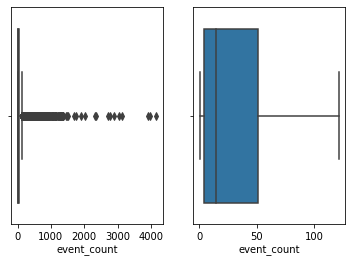

In [21]:
_, ax = plt.subplots(1,2)
sns.boxplot(x=df_original.event_count, ax=ax[0])
sns.boxplot(x=df_original.event_count, ax=ax[1], showfliers=False,)
print('event count median: ', df_original.event_count.median())

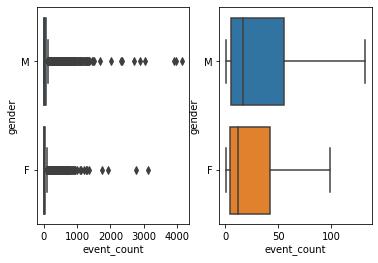

In [22]:
_, ax = plt.subplots(1,2)
sns.boxplot(x=df_original.event_count, y=df_original.gender, ax=ax[0])
sns.boxplot(x=df_original.event_count, y=df_original.gender, ax=ax[1], showfliers=False)

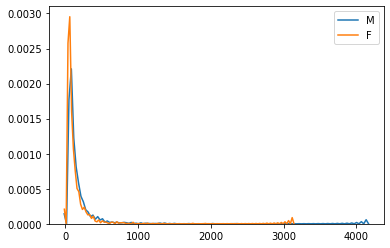

In [23]:
sns.kdeplot(df_original[df_original.gender=='M'].event_count, label='M')
sns.kdeplot(df_original[df_original.gender=='F'].event_count, label='F')

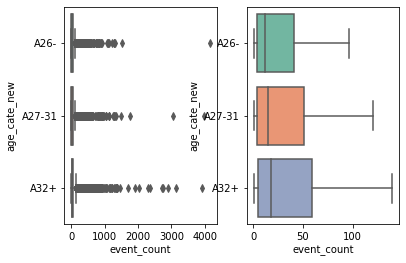

In [24]:
_, ax = plt.subplots(1,2)
sns.boxplot(x=df_original.event_count, y=df_original.age_cate_new, palette='Set2', ax=ax[0])
sns.boxplot(x=df_original.event_count, y=df_original.age_cate_new, palette='Set2', ax=ax[1], showfliers=False)

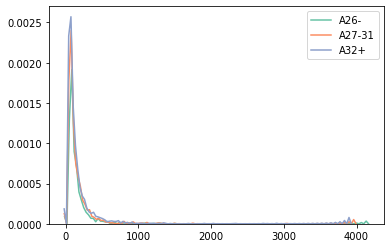

In [25]:
for i,age_grp in enumerate(df_original.age_cate_new.unique().sort_values()):
    sns.kdeplot(df_original[df_original.age_cate_new==age_grp].event_count, label=age_grp, color=sns.color_palette('Set2')[i])

**Comments:**

- Note that, while counts can indicate how often the users use their phones, the actual events number might also highly affect by many tech issues. e.g., certain users might have use thier phone very often, but due to technique reason they were not logged. 
- Here I extract this feature not because I am counting on to improve performance, but to use it as a indicator why the model might not have performed well. e.g., It is understandable, less events means less data, and it is very hard (if possible) for a machine to learn from lack of data. At the end, I would like to justify my intuition, less events has a higher corelationship with bad performance.
- Still event number can indicate user activity. That being said, male users are more active than female ones (from the boxplot). The age group 32+ users are more acitve than the rest (also from the boxplot). However, neither of such trends are significant.
- Notice that the median number of event count is 15, the 75 percentile is 50. In other words, the machine needs to learn something out of the 50 events for 75% of the users. For a complicated case like this to study customer behaviors, this might be too low.

## EDA: hour against target
- All the data are recorded from one week in 2016 May (can be found in the orignal datasets).
- The hour features are extracted in a way that, first I extract hours based on timestamps. (note that there is only 1 timezone, GMT+8, so there is no conversion required.)
- Then, the hour features here are extracted from the timestamp and bin-wised into 24 sub-groups. The extracted features represent the static time event distribution, e.g. hour_6 = 0.2 indicates that this user have 20% of the events record at hour_6.

In [26]:
# the df need some rearrangement for pd to handel, using melt
# df_original[col_target+col_hour]

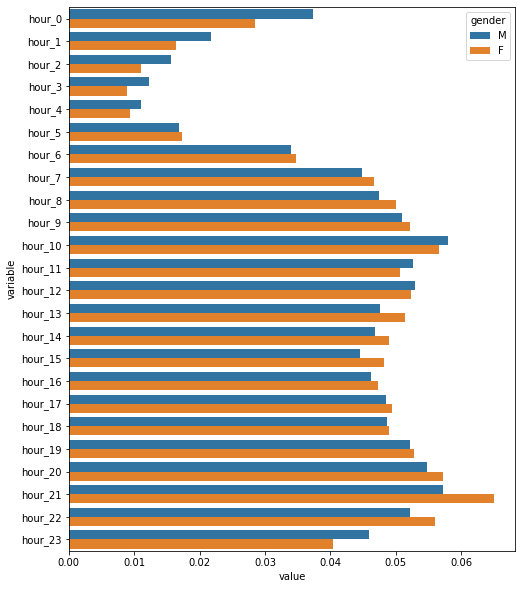

In [27]:
df_melt_tmp = pd.melt(df_original[col_target+col_hour], id_vars=['gender'], value_vars=col_hour)
# df_melt_tmp
_, ax = plt.subplots(figsize=(8,2*5))
sns.barplot(data=df_melt_tmp, x='value',  hue='gender', y='variable', ax=ax, ci=None)

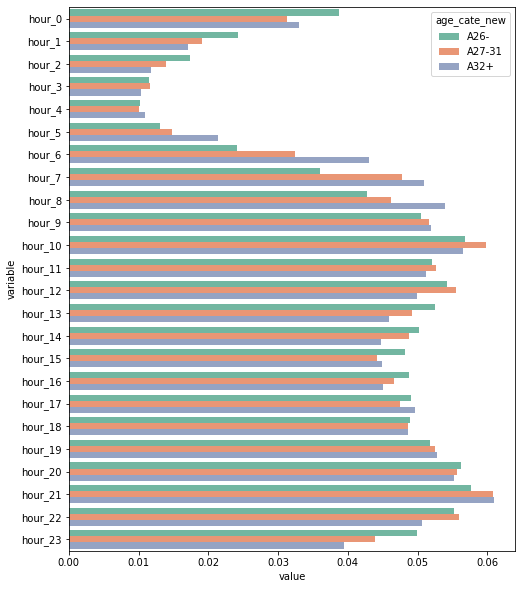

In [28]:
df_melt_tmp = pd.melt(df_original[col_target+col_hour], id_vars=['age_cate_new'], value_vars=col_hour)
# df_melt_tmp
_, ax = plt.subplots(figsize=(8,10))
sns.barplot(data=df_melt_tmp, x='value',  hue='age_cate_new', y='variable', ax=ax, palette='Set2', ci=None)

**Comments:**

- From the plots, it is undertandable that between hour_1 to hour_5 there are few events record (users were in sleep probabely).
- In the analysis against age_group, while your people are more active in hour_23 and hour_0, users from older group are more acitve in hour_5 to hour_8.

## EDA: (app) label
- each app has one or several app labels. e.g. Facebook might have labels "social media," "entertainment," etc.
- In the original database, there are 300+ different labels. I choose the most frequent 50 ones as featuers and use term frequency to represent user app label using behavior. e.g. if label__786 = 0, it means the user didn't apps associated with that label (according to the record). if label__786=0.02, it indicates that among all the chosen labels, the user uses apps that belong to label__786 two out of one hundred times.


In [29]:
# similarly, the df need some rearrangement for pd to handel, using melt
# df_original[col_target+col_label[:20]]
# df_melt_tmp.groupby('variable').mean().sort_values('value', ascending=False).index

In [30]:
# df_melt_tmp = pd.melt(df_original[col_target+col_label[:20]], id_vars=['gender'], value_vars=col_label[:20])
# # df_melt_tmp
# order_tmp = df_melt_tmp.groupby('variable').mean().sort_values('value', ascending=False).index
# _, ax = plt.subplots(figsize=(8,2*5))
# sns.barplot(data=df_melt_tmp, x='value',  hue='gender', y='variable', ax=ax, ci=None, order=order_tmp)

In [31]:
df_melt_tmp = pd.melt(df_original[col_target+col_label[:20]], id_vars=['gender'], value_vars=col_label[:20])
order_tmp = df_melt_tmp.groupby('variable').mean().sort_values('value', ascending=False).index.values
df_melt_tmp = pd.melt(df_original[col_target+col_label[:20]], id_vars=['gender'], value_vars=col_label[:20])
df_label_categories = pd.read_csv(DIR_CURRENT+ '/data/talkingdata-mobile-user-demographics/label_categories.csv')
# df_label_categories.head()

label_list_tmp = [int(label_id[7:]) for label_id in order_tmp]
# label_list_tmp

pd.merge(left=pd.DataFrame({'label_id': label_list_tmp}),
        right=df_label_categories,
         how='left',
        on='label_id').head()

,label_id,category
0,548,Industry tag
1,549,Property Industry 1.0
2,704,Property Industry 2.0
3,302,unknown
4,303,unknown


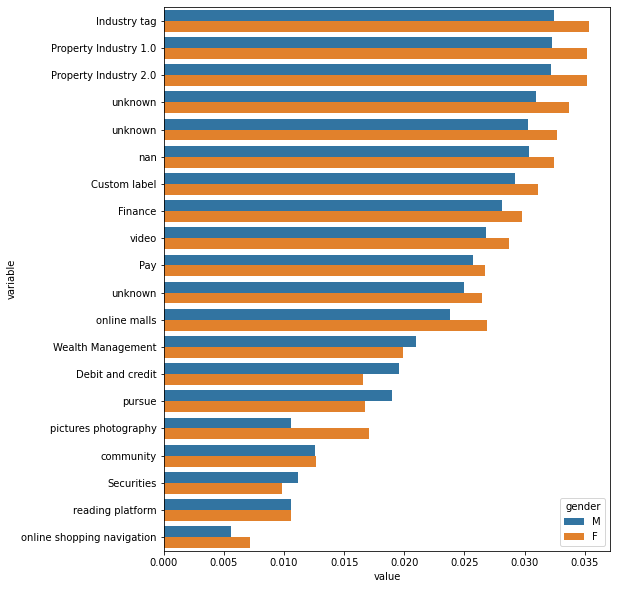

In [32]:
df_melt_tmp = pd.melt(df_original[col_target+col_label[:20]], id_vars=['gender'], value_vars=col_label[:20])
# df_melt_tmp
order_tmp = df_melt_tmp.groupby('variable').mean().sort_values('value', ascending=False).index
_, ax = plt.subplots(figsize=(8,10))
sns.barplot(data=df_melt_tmp, x='value',  hue='gender', y='variable', ax=ax, ci=None, order=order_tmp, )

ax.set_yticklabels(pd.merge(left=pd.DataFrame({'label_id': label_list_tmp}),
        right=df_label_categories,
                            how='left',
        on='label_id').category.values)
plt.show()

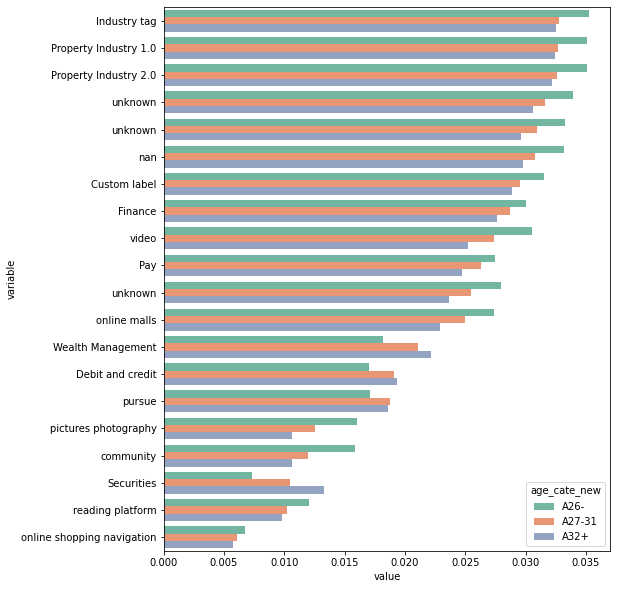

In [33]:
df_melt_tmp = pd.melt(df_original[col_target+col_label[:20]], id_vars=['age_cate_new'], value_vars=col_label[:20])
# df_melt_tmp
order_tmp = df_melt_tmp.groupby('variable').mean().sort_values('value', ascending=False).index
_, ax = plt.subplots(figsize=(8,10))
sns.barplot(data=df_melt_tmp, x='value',  hue='age_cate_new', y='variable', ax=ax, ci=None, order=order_tmp, palette='Set2')

ax.set_yticklabels(pd.merge(left=pd.DataFrame({'label_id': label_list_tmp}),
        right=df_label_categories,
                            how='left',
        on='label_id').category.values)
plt.show()



**Comments:**

- some lables are quite popular, but I am not sure if they are very helpful for this demographics prediction task. e.g., 'industry tag,' 'property industry' just some labels that every cell phone have, thus every users will use.
- We should pay more attention to labels like "pictures photography" and "online malls". It seems like female users are more intersted in apps belong to these two categories and thus use them more often.
- In the age group analysis, "online malls,' 'pictures photography,' 'community' draw more attention from young people, while 'wealth management,' 'securities' are more popular among users from older group. 

## EDA: app (id) features
- the analysis on app (id) are similar to app labels, from which we can have some understanding which app or apps are more popular.
- Note we don't have any clue about the name of the apps except the app id and associated labels. e.g. facebook app would be designated as something like "93933394". 
- Also, I chose the top 20 apps out of the 20,000+ apps for the 'half-way-done' cross-table, again term-frequency-style.

In [34]:
# similarly, the df need some rearrangement for pd to handel, using melt
# df_original[col_target+col_app].head()

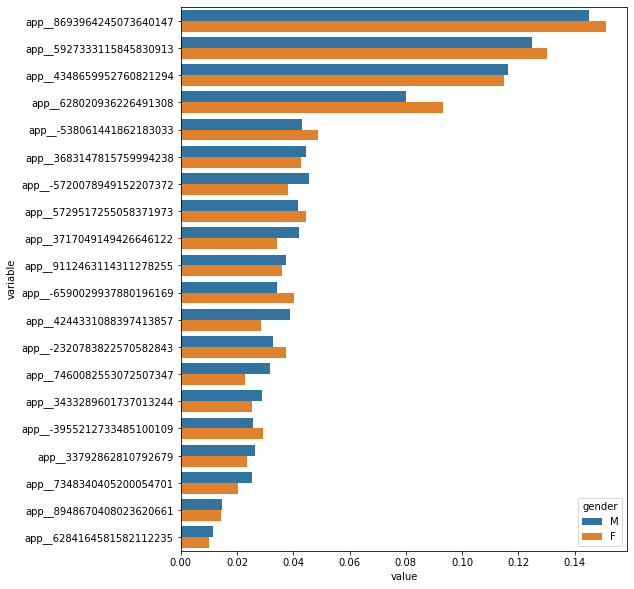

In [35]:
df_melt_tmp = pd.melt(df_original[col_target+col_app], id_vars=['gender'], value_vars=col_app)
# df_melt_tmp
order_tmp = df_melt_tmp.groupby('variable').mean().sort_values('value', ascending=False).index
_, ax = plt.subplots(figsize=(8,2*5))
sns.barplot(data=df_melt_tmp, x='value',  hue='gender', y='variable', ax=ax, ci=None, order=order_tmp)

# ax.set_yticklabels(pd.merge(left=pd.DataFrame({'label_id': label_list_tmp}),
#         right=df_label_categories,
#                             how='left',
#         on='label_id').category.values)
plt.show()

In [36]:
df_app_labels = pd.read_csv(DIR_CURRENT+ '/data/talkingdata-mobile-user-demographics/app_labels.csv')
df_app_labels.head()

app_list_tmp = [int(app_id[5:]) for app_id in order_tmp]
# label_list_tmp

df_link_tmp = pd.merge(left=pd.DataFrame({'app_id': app_list_tmp}),
        right=df_app_labels,
         how='left',
        on='app_id')
df_link_tmp = pd.merge(left=df_link_tmp,
        right=df_label_categories,
                            how='left',
        on='label_id')
# df_link_tmp.head()

# df_link_tmp.groupby('app_id', sort=False).category.unique().head()

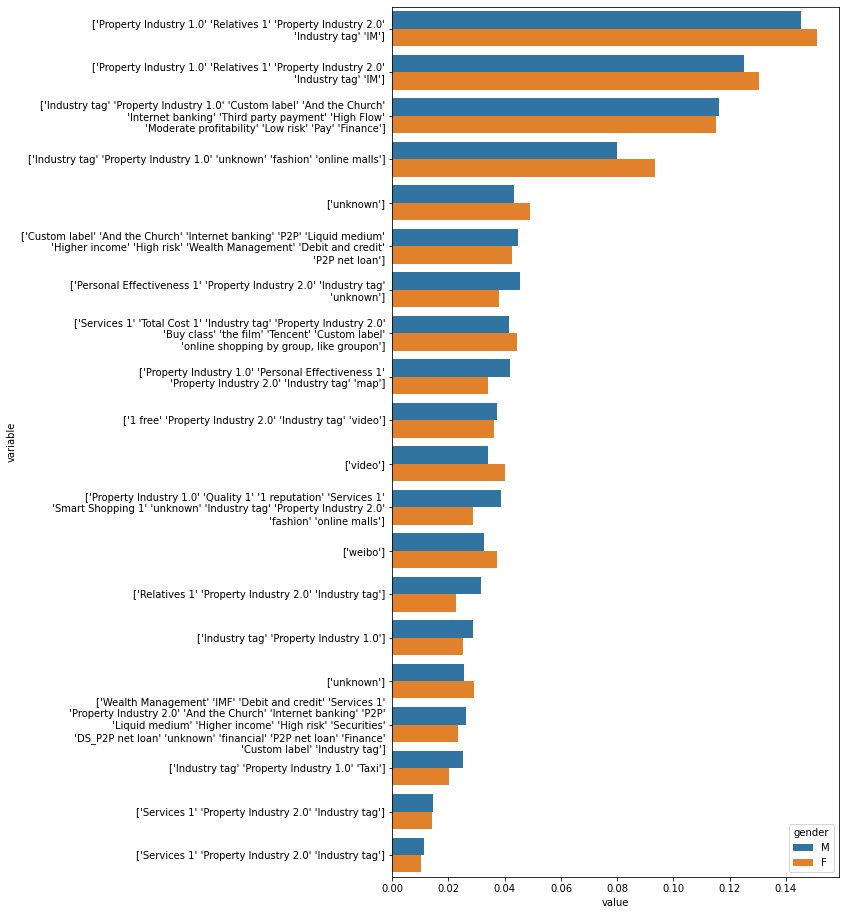

In [37]:
df_melt_tmp = pd.melt(df_original[col_target+col_app], id_vars=['gender'], value_vars=col_app)
# df_melt_tmp
order_tmp = df_melt_tmp.groupby('variable').mean().sort_values('value', ascending=False).index
_, ax = plt.subplots(figsize=(8,2*8))
sns.barplot(data=df_melt_tmp, x='value',  hue='gender', y='variable', ax=ax, ci=None, order=order_tmp)

tick_tmp = [str(iterm) for iterm in df_link_tmp.groupby('app_id', sort=False).category.unique().values]
ax.set_yticklabels(tick_tmp)
plt.show()

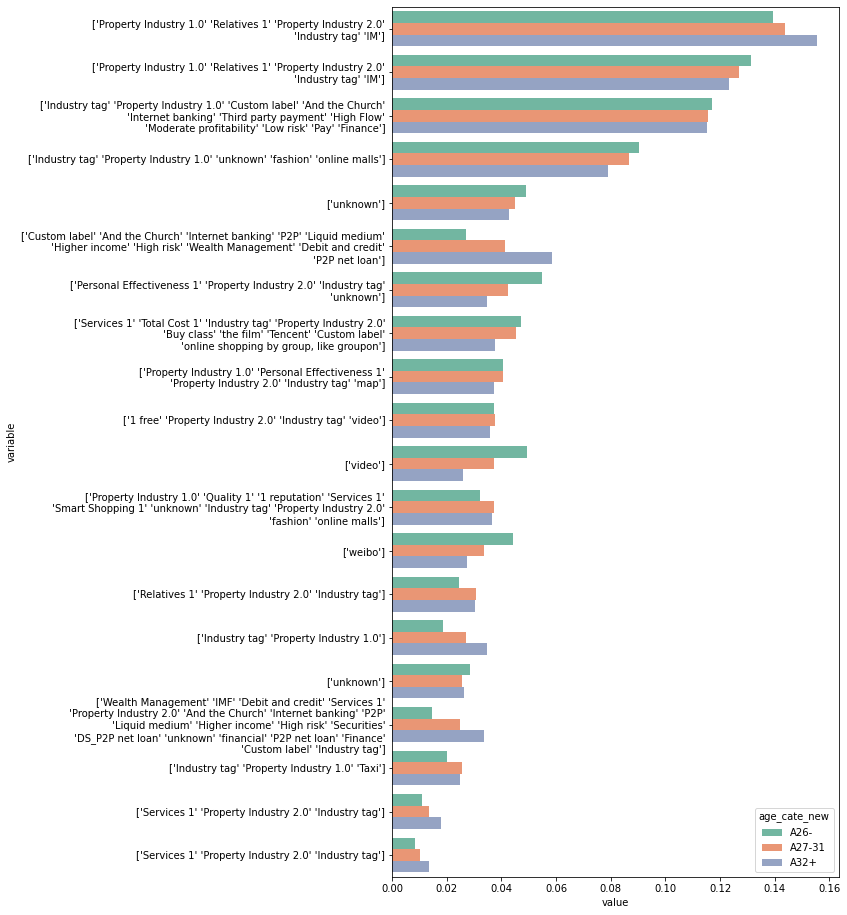

In [38]:
df_melt_tmp = pd.melt(df_original[col_target+col_app], id_vars=['age_cate_new'], value_vars=col_app)
# df_melt_tmp
order_tmp = df_melt_tmp.groupby('variable').mean().sort_values('value', ascending=False).index
_, ax = plt.subplots(figsize=(8,16))
sns.barplot(data=df_melt_tmp, x='value',  hue='age_cate_new', y='variable', ax=ax, ci=None, order=order_tmp, palette='Set2')

tick_tmp = [str(iterm) for iterm in df_link_tmp.groupby('app_id', sort=False).category.unique().values]
ax.set_yticklabels(tick_tmp)
plt.show()

In [39]:
##

**Comments:**

- similar to app lables, some apps (including the most 'popular' one) are no distinguiable among user groups.
- However, if we look at the app with label 'weibo' ( a Chinese version of Twitter), which is more popular among young users. Another such app draw young users attention is the one labeled 'video'. 
- For older users, they seem to care more about apps with labels 'wealth management,' 'IMF,' 'P2P loans,' etc.
- Once again, female users are interested in the app labeled with 'online malls,' 'fashion'.
- Note, the choice of 20 most popular apps used for analysis and training is not the best idea, e.g., we have noticed that the most popular ones are not neccessarily with the most prediction power. But to build the pipeline, let's just start with this premature number and modify it later.

## EDA: (phone) brand against target
- as the name suggests, brand describes what device brand a user uses.
- I chose the most popular 20 brands and one-hot-encode in the 'half-way-done' dataframe.

In [40]:
# similarly, the df need some rearrangement for pd to handel, using melt
df_original[col_target+col_brand].head()

,gender,age,group,age_cate,age_cate_new,brand_A plus,brand_China Mobile,brand_Gionee,brand_HTC,brand_Huawei,brand_Kupai,brand_LG,brand_Lenovo,brand_Meizu,brand_Nubia,brand_OPPO,brand_Qiku,brand_Samsung,brand_Sony,brand_TCL,brand_TV Plus,brand_Xiaomi,brand_ZTE,brand_hammer,brand_other,brand_vivo
0,M,36.0,M32-38,A32-40,A32+,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M,33.0,M32-38,A32-40,A32+,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,F,34.0,F33-42,A32-40,A32+,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,F,34.0,F33-42,A32-40,A32+,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,M,33.0,M32-38,A32-40,A32+,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


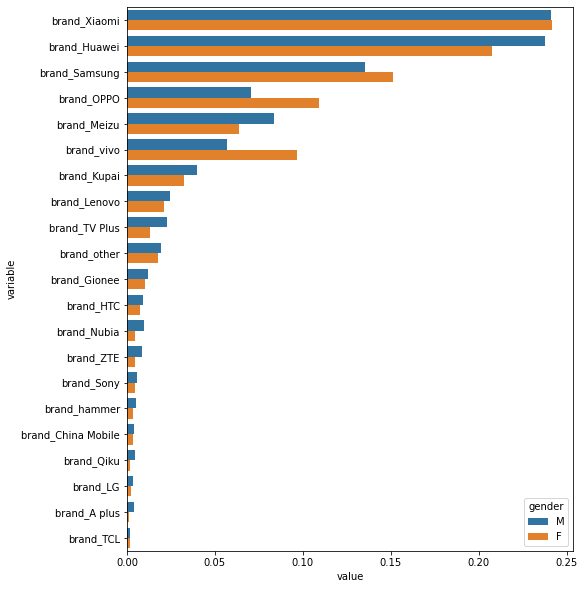

In [41]:
df_melt_tmp = pd.melt(df_original[col_target+col_brand], id_vars=['gender'], value_vars=col_brand)
# df_melt_tmp
order_tmp = df_melt_tmp.groupby('variable').mean().sort_values('value', ascending=False).index
_, ax = plt.subplots(figsize=(8,2*5))
sns.barplot(data=df_melt_tmp, x='value',  hue='gender', y='variable', ax=ax, ci=None, order=order_tmp)

plt.show()

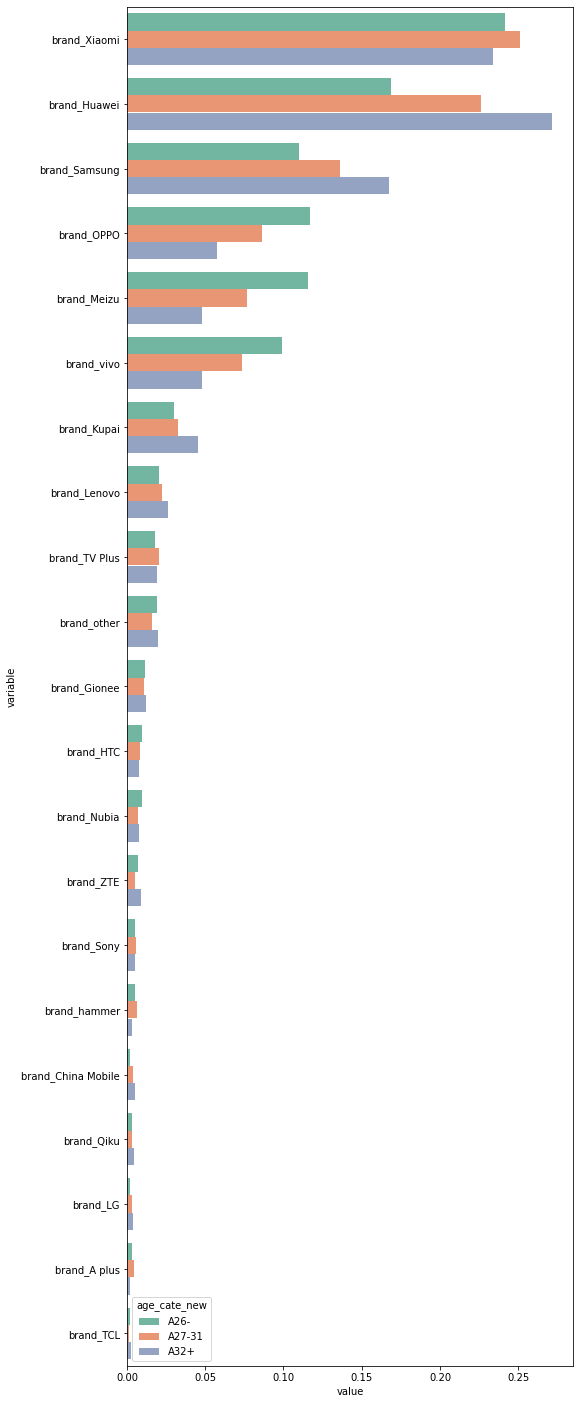

In [42]:
df_melt_tmp = pd.melt(df_original[col_target+col_brand], id_vars=['age_cate_new'], value_vars=col_brand)
# df_melt_tmp
order_tmp = df_melt_tmp.groupby('variable').mean().sort_values('value', ascending=False).index
_, ax = plt.subplots(figsize=(8,5*5))
sns.barplot(data=df_melt_tmp, x='value',  hue='age_cate_new', y='variable', ax=ax, ci=None, order=order_tmp, palette='Set2')

plt.show()

## EDA: (phone) model against target

In [43]:
# similarly, the df need some rearrangement for pd to handel, using melt
df_original[col_target+col_br_model[:20]].head()

,gender,age,group,age_cate,age_cate_new,br_model_A plus-One,br_model_Gionee-F103,br_model_Huawei-3C glory,br_model_Huawei-4-head,br_model_Huawei-4A glory,br_model_Huawei-Ascend G7,br_model_Huawei-Ascend P6,br_model_Huawei-Ascend P7,br_model_Huawei-Ascend P8,br_model_Huawei-Enjoy 5,br_model_Huawei-Enjoy 5S,br_model_Huawei-Glory 3X Play Edition,br_model_Huawei-Glory 6,br_model_Huawei-Glory 6 Plus,br_model_Huawei-Glory 6 plus,br_model_Huawei-Glory 7,br_model_Huawei-Glory 7i,br_model_Huawei-Glory Play 4,br_model_Huawei-Glory Play 4X,br_model_Huawei-Glory Play 5
0,M,36.0,M32-38,A32-40,A32+,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M,33.0,M32-38,A32-40,A32+,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,F,34.0,F33-42,A32-40,A32+,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,F,34.0,F33-42,A32-40,A32+,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M,33.0,M32-38,A32-40,A32+,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


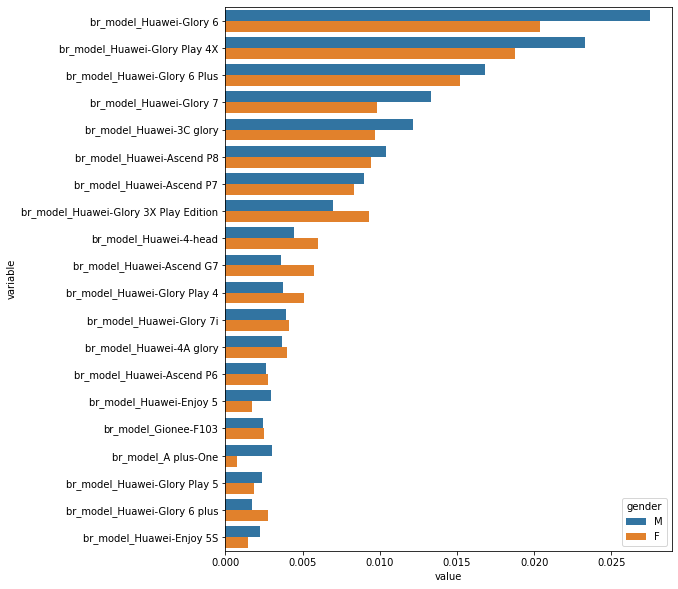

In [44]:
df_melt_tmp = pd.melt(df_original[col_target+col_br_model[:20]], id_vars=['gender'], value_vars=col_br_model[:20])
# df_melt_tmp
order_tmp = df_melt_tmp.groupby('variable').mean().sort_values('value', ascending=False).index
_, ax = plt.subplots(figsize=(8,2*5))
sns.barplot(data=df_melt_tmp, x='value',  hue='gender', y='variable', ax=ax, ci=None, order=order_tmp)

plt.show()

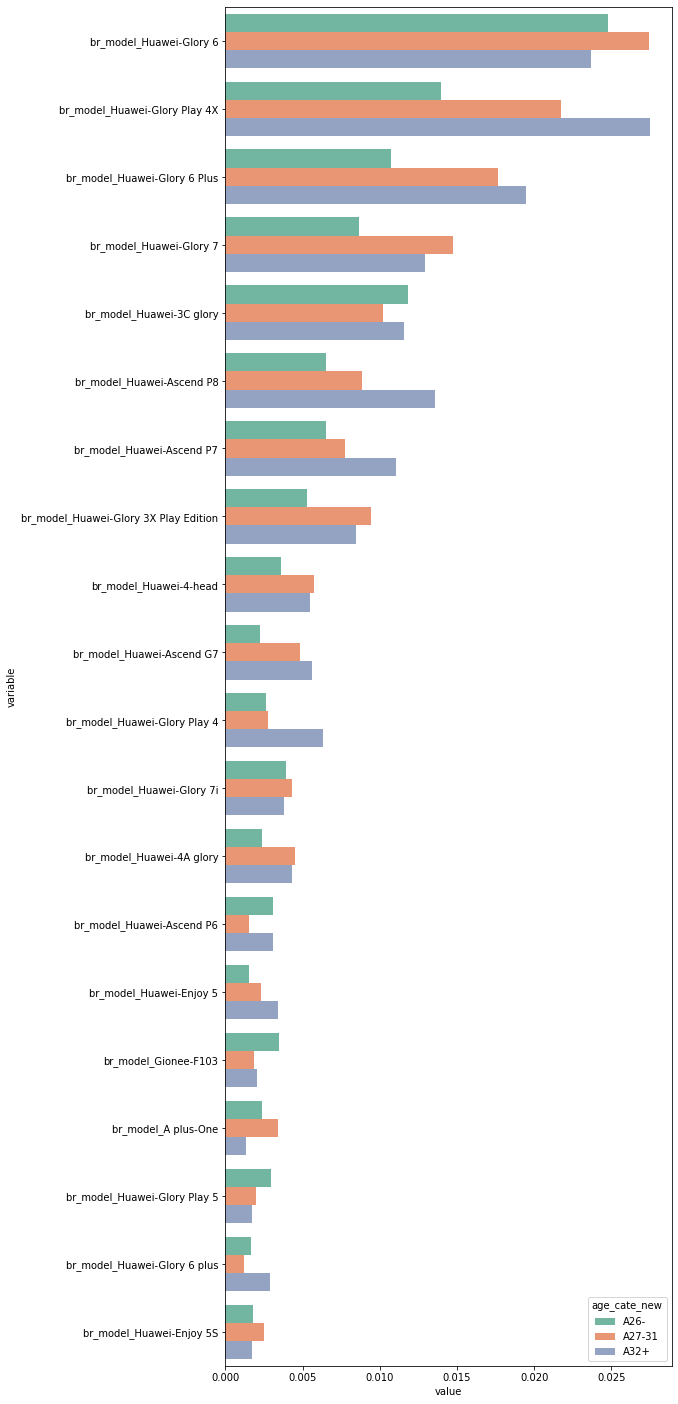

In [45]:
df_melt_tmp = pd.melt(df_original[col_target+col_br_model[:20]], id_vars=['age_cate_new'], value_vars=col_br_model[:20])
# df_melt_tmp
order_tmp = df_melt_tmp.groupby('variable').mean().sort_values('value', ascending=False).index
_, ax = plt.subplots(figsize=(8,5*5))
sns.barplot(data=df_melt_tmp, x='value',  hue='age_cate_new', y='variable', ax=ax, ci=None, order=order_tmp, palette='Set2')

plt.show()

## Summary of EDA
- We've walked through the EDA on the 'half-way-done' datasets, which is created from the original relational database with some data cleaning, data wrangling, and data preprocessing.
- More specifically, we visualize the features against targets to explore data opportunities, i.e., using data to predict the user demographics.
- It is not a trivial job for the prediction task, since the underlying mechanics between our features and targets are not simply linear. Another challenge is a large portion of features are categorical variables, and ceratin NLP skills are required. 
- But at least, we know what situation we are facing now, let's build several models to solve the classification problem.
# Bounus
as a data storytelling showstopper, we can wrap up with using gps, time_stamp across target
# LINK


# Model preparation
- train-test split
- feature engineering (select K best, PCA)


In [46]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23290 entries, 0 to 23289
Columns: 236 entries, device_id to age_cate_new
dtypes: category(2), float64(229), int64(3), object(2)
memory usage: 42.4+ MB


## train-test split
- train-test split is part of the modeling design, since we need to split the dataset, part for training, part for evaluation.
- For the dataset (23,290 rows), I will use 6:2:2 split (train-validation-test), the validation set is helpful to spot overfitting and other deficency in performance, so that we can improve the model before bring it to the test set, 
- test set is the unseen data to the model, which acts as the final judge determines the performance of the model.

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
Y = df_original[col_target].copy()

Y_dummy = pd.get_dummies(df_original[col_target])
Y_dummy.head()

,age,gender_M,gender_F,group_F23-,group_F24-26,group_F27-28,group_F29-32,group_F33-42,group_F43+,group_M22-,group_M23-26,group_M27-28,group_M29-31,group_M32-38,group_M39+,age_cate_A22-,age_cate_A23-26,age_cate_A27-28,age_cate_A29-31,age_cate_A32-40,age_cate_A40+,age_cate_new_A26-,age_cate_new_A27-31,age_cate_new_A32+
0,36.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
1,33.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
2,34.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,34.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,33.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1


In [49]:
X = df_original.drop(col_target, axis=1).copy()
X.drop('device_id', axis=1, inplace=True)
# X.head()

# building pipline start with 1 target: gender
y = Y_dummy[['gender_M']]
# Y.head()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=2/10, random_state=RANDOM_STATE)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=2/8, random_state=RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2/10, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=2/8, random_state=RANDOM_STATE)


In [50]:
# check numbers
print (len(X_train), len(Y_train), len(y_train))
print (len(X_val), len(Y_val), len(y_val))
print (len(X_test), len(Y_test), len(y_test))

len(X_train)+len(X_val)+len(X_test)

13974 13974 13974
4658 4658 4658
4658 4658 4658


23290

## Feature engineering


### Select K best
Even though we have performed certain preprocessing and limited the number of features in the 'half-way-done' dataset, but we still have 235 featuers. This might still be too much for many machine learning models. The following is a demonstration of using selectKbest to further select the useful features (hopefully).

In [51]:
from sklearn.feature_selection import SelectKBest, chi2

In [52]:
kbest = SelectKBest()

In [53]:
kbest.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SelectKBest(k=10, score_func=<function f_classif at 0x7fd54ab07730>)

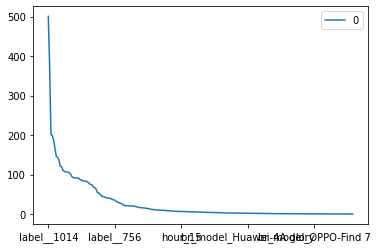

In [54]:
# visulizae the scores, (sorted from top to bottom)
df_kbest = pd.DataFrame(kbest.scores_)
df_kbest.index = X_train.columns
df_kbest.sort_values(by=0, ascending=False).plot()

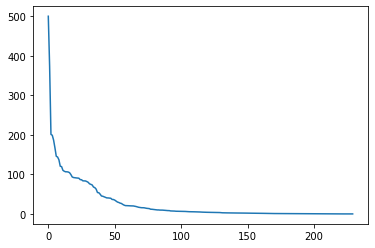

In [55]:
# visulizae the scores, (sorted from top to bottom)
plt.plot(range(len(df_kbest.sort_values(by=0, ascending=False))), df_kbest.sort_values(by=0, ascending=False))

In [56]:
# show how many labels are within the top 100 most selectKbest features
for col in [col_gps, col_hour, col_event_count, col_label, col_app, col_brand, col_br_model]:
    print (str(col)[:5], ': ', len(np.intersect1d(df_kbest.sort_values(by=0, ascending=False).index[:100], col)))

['lat :  6
['hou :  6
['eve :  1
['lab :  46
['app :  13
['bra :  7
['br_ :  19


In [57]:
# show how many labels are within the top 100 most selectKbest features
for col in [col_gps, col_hour, col_event_count, col_label, col_app, col_brand, col_br_model]:
    print (str(col)[:5], ': ', len(np.intersect1d(df_kbest.sort_values(by=0, ascending=False).index[:50], col)))

['lat :  6
['hou :  0
['eve :  1
['lab :  33
['app :  5
['bra :  2
['br_ :  1


In [58]:
# display the most 'useful' labels.
df_kbest[df_kbest.index.isin(col_label)].sort_values(by=0, ascending=False).reset_index().head(20)

,index,0
0,label__1014,500.564251
1,label__209,373.970932
2,label__783,201.407746
3,label__757,199.185614
4,label__779,186.737400
5,label__751,145.981585
6,label__128,144.025877
7,label__263,136.996829
8,label__1015,120.720120
9,label__781,119.827712


In [59]:

# df_label_categories = pd.read_csv('./talkingdata-mobile-user-demographics/label_categories.csv')
# df_label_categories.head()

label_list_tmp = [int(label[7:]) for label in df_kbest[df_kbest.index.isin(col_label)].sort_values(by=0, ascending=False).reset_index()['index'].values[:10]]
label_list_tmp
# label_list_tmp

pd.merge(left=pd.DataFrame({'label_id': label_list_tmp}),
        right=df_label_categories,
         how='left',
        on='label_id')

,label_id,category
0,1014,Consumer Finance
1,209,pictures photography
2,783,High risk
3,757,P2P
4,779,Higher income
5,751,Bank financing
6,128,online malls
7,263,Debit and credit
8,1015,mobile bank
9,781,Low profitability


**Comments:**

- According to selectKBest analysis, the most useful features to predict target is label, lat, e.g. in the top 50 most 'useful' featuers, 33 of them are label features, 6 of them are GPS feautures, 
- while hour features are supprisingly not very useful.
- With a closer look at the most useful label_id and their associated category, the top 10 useful features are related to 'consumer finance,' 'pictures photography,' high risk,' 'P2P,' etc.

**Notes:**

- normally I don't rely on SelectKBest for feature selection. Because it didn't take into account the non linear relationship. For this reason, I will remain all the features as they are for now.
- Here, I will select the top 100 features for demonstration purpose.

In [60]:
# kbest.set_params(k=100)
X_train_best100 = X_train[df_kbest.sort_values(by=0, ascending=False).index[:100]].copy()
X_train_best100.head()

,label__1014,label__209,label__783,label__757,label__779,enc_by_device_4_app_id,label__751,label__128,label__263,label__1015,label__781,label__778,long_std,long_mean,label__775,long_median,label__704,app__4244331088397413857,label__710,app__628020936226491308,enc_by_device_4_label_id,label__713,label__302,label__405,brand_vivo,label__549,label__548,label__564,lat_std,label__1007,app__7460082553072507347,lat_median,label__303,lat_mean,app__3717049149426646122,label__-1,label__795,label__251,label__714,label__782,...,label__909,label__932,label__786,brand_Nubia,br_model_Meizu-MX5,br_model_Samsung-Galaxy Note 2,app__5927333115845830913,hour_2,br_model_Xiaomi-Red rice Note3,br_model_vivo-X5Pro,brand_Meizu,brand_TV Plus,label__262,brand_Huawei,hour_1,app__-6590029937880196169,hour_21,hour_3,br_model_Samsung-Galaxy Note 3,br_model_Nubia-Z9 mini,brand_Qiku,app__8693964245073640147,br_model_OPPO-R7s,br_model_TV Plus-Super phone 1,label__721,app__5729517255058371973,br_model_OPPO-R7,br_model_hammer-T1,br_model_vivo-X3L,br_model_Lenovo-Gold fighter A8,br_model_Meizu-PRO5,label__719,hour_23,app__-538061441862183033,br_model_A plus-One,br_model_Qiku-Youth version,br_model_Huawei-Glory 6 plus,br_model_OPPO-R7 Plus,app__3433289601737013244,br_model_vivo-X5Max+
9676,0.000000,0.026316,0.026316,0.026316,0.026316,40,0.000000,0.026316,0.026316,0.026316,0.000000,0.026316,0.000000,0.000000,0.026316,0.00,0.026316,0.000000,0.026316,0.090909,78,0.026316,0.026316,0.026316,0.0,0.026316,0.026316,0.026316,0.000000,0.026316,0.0,0.00,0.026316,0.000000,0.000000,0.026316,0.026316,0.026316,0.026316,0.026316,...,0.026316,0.026316,0.026316,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.026316,1.0,0.0,0.090909,0.000000,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.026316,0.090909,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.090909,0.0
17257,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.027027,0.027027,0.027027,0.027027,0.027027,0.000000,23.017228,109.230833,0.027027,113.98,0.027027,0.166667,0.027027,0.166667,0,0.027027,0.027027,0.027027,0.0,0.027027,0.027027,0.027027,4.670806,0.027027,0.0,23.13,0.027027,22.165833,0.000000,0.027027,0.000000,0.027027,0.027027,0.027027,...,0.000000,0.000000,0.027027,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.027027,0.0,0.0,0.000000,0.041667,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.027027,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.062500,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
8844,0.031250,0.000000,0.031250,0.031250,0.031250,30,0.031250,0.031250,0.031250,0.031250,0.031250,0.000000,49.879319,24.094000,0.031250,0.00,0.031250,0.000000,0.031250,0.142857,60,0.031250,0.031250,0.031250,0.0,0.031250,0.031250,0.031250,13.530805,0.031250,0.0,0.00,0.031250,6.536000,0.000000,0.031250,0.000000,0.031250,0.031250,0.000000,...,0.000000,0.000000,0.031250,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.031250,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.066667,0.142857,0.0,0.0,0.0,0.0,0.000000,0.0
14529,0.000000,0.000000,0.026316,0.026316,0.026316,31,0.026316,0.026316,0.026316,0.026316,0.026316,0.000000,0.000000,0.000000,0.026316,0.00,0.026316,0.000000,0.026316,0.200000,75,0.026316,0.026316,0.026316,0.0,0.026316,0.026316,0.026316,0.000000,0.026316,0.0,0.00,0.026316,0.000000,0.000000,0.026316,0.026316,0.026316,0.026316,0.026316,...,0.000000,0.000000,0.026316,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.026316,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.026316,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.200000,0.0
22515,0.025641,0.000000,0.025641,0.025641,0.025641,27,0.025641,0.025641,0.025641,0.025641,0.025641,0.000000,0.000000,0.000000,0.025641,0.00,0.025641,0.000000,0.025641,0.142857,82,0.025641,0.025641,0.025641,0.0,0.025641,0.025641,0.025641,0.000000,0.025641,0.0,0.00,0.025641,0.000000,0.142857,0.025641,0.025641,0.025641,0.025641,0.025641,...,0.025641,0.025641,0.025641,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.025641,0.0,0.0,0.000000,0.000000,0.0,

In [61]:
X_train_best100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13974 entries, 9676 to 19366
Data columns (total 100 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   label__1014                      13974 non-null  float64
 1   label__209                       13974 non-null  float64
 2   label__783                       13974 non-null  float64
 3   label__757                       13974 non-null  float64
 4   label__779                       13974 non-null  float64
 5   enc_by_device_4_app_id           13974 non-null  int64  
 6   label__751                       13974 non-null  float64
 7   label__128                       13974 non-null  float64
 8   label__263                       13974 non-null  float64
 9   label__1015                      13974 non-null  float64
 10  label__781                       13974 non-null  float64
 11  label__778                       13974 non-null  float64
 12  long_std      

### PCA
PCA is a very useful feature engineering tool. PCA can effectively extracted useful features by orthogonizing the data, and deal with high-coorelation featuers. Note that certain scaling methods are required to achieve the better results. Here are the steps for PCA.
- correlation check (heatmap)
- scaling
- pca in action

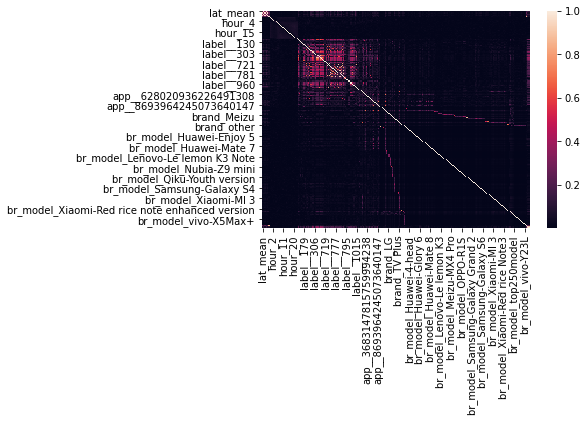

In [62]:
# check coorelation using heatmap
# here, the high-correlation issue is not servere. 
corr_mtrx = X_train.corr()
sns.heatmap(abs(corr_mtrx))

In [63]:
# scaling (I like to use PowerTransformer, StandardScaler, QuantileTransformer)
from sklearn.preprocessing import PowerTransformer, StandardScaler, QuantileTransformer

pwtransformer = PowerTransformer()
X_train_pwtrans = pwtransformer.fit_transform(X_train)


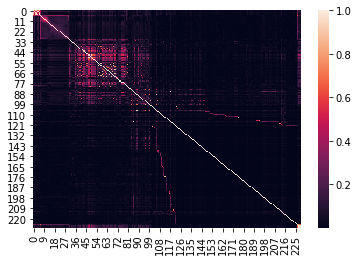

In [64]:
corr_mtrx = pd.DataFrame(X_train_pwtrans).corr()
sns.heatmap(abs(corr_mtrx))

In [65]:
from sklearn.decomposition import PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_pwtrans)

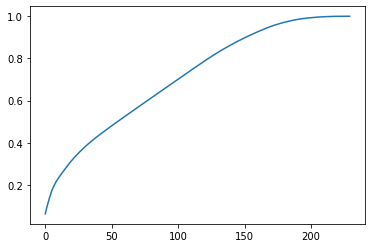

In [66]:
plt.plot(pca.explained_variance_ratio_.cumsum())

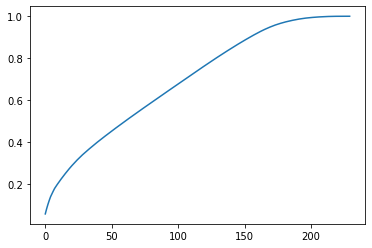

In [67]:
# standarscaler
sstransformer = StandardScaler()
X_train_sstrans = sstransformer.fit_transform(X_train)

pca = PCA()
X_train_pca = pca.fit_transform(X_train_sstrans)

plt.plot(pca.explained_variance_ratio_.cumsum())

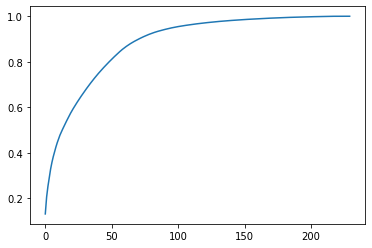

In [68]:
# quantile
qttransformer = QuantileTransformer()
X_train_qqtrans = qttransformer.fit_transform(X_train)

pca = PCA()
X_train_pca = pca.fit_transform(X_train_qqtrans)

plt.plot(pca.explained_variance_ratio_.cumsum())

**Comments:**

it seems quantile transformer can best capture the explained variance. 

But what about after selectKBest

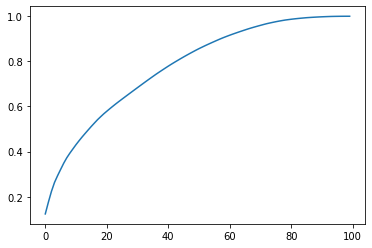

In [69]:
# X_train_best100
# power transformer
pwtransformer = PowerTransformer()
X_train_pwtrans = pwtransformer.fit_transform(X_train_best100)

pca = PCA()
X_train_pca = pca.fit_transform(X_train_pwtrans)

plt.plot(pca.explained_variance_ratio_.cumsum())

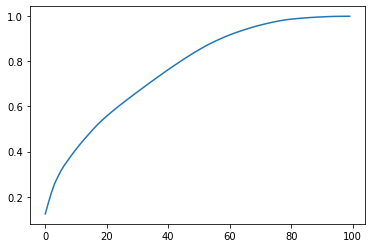

In [70]:
# X_train_best100
# standarscaler
sstransformer = StandardScaler()
X_train_sstrans = sstransformer.fit_transform(X_train_best100)

pca = PCA()
X_train_pca = pca.fit_transform(X_train_sstrans)

plt.plot(pca.explained_variance_ratio_.cumsum())

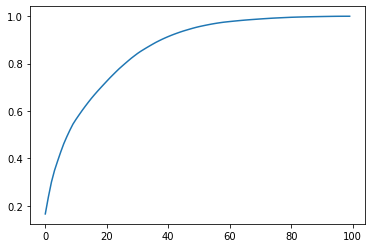

In [71]:
# X_train_best100
# standarscaler
qttransformer = QuantileTransformer()
X_train_qttrans = qttransformer.fit_transform(X_train_best100)

pca = PCA()
X_train_pca = pca.fit_transform(X_train_qttrans)

plt.plot(pca.explained_variance_ratio_.cumsum())

**PCA in action (pipeline)**

The quantile transformed data after pca is not bad. But in order to keep the dataset light weighted, I will 
- first select K=100 best features
- use quantile
- select top 60 principle components

here it comes (on validation data and test data)

In [72]:
# USE X_TRAIN
# X_train_pca = X_train_pca

qttransformer = QuantileTransformer(random_state=RANDOM_STATE)
X_train_qttrans = qttransformer.fit_transform(X_train)
pca = PCA(n_components=150, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_qttrans)

# val
# X_val_best100 = X_val.copy()
# X_val_best100.head()

X_val_qttrans = qttransformer.transform(X_val)
X_val_pca = pca.transform(X_val_qttrans)

# # test
# X_test_best100 = X_test[df_kbest.sort_values(by=0, ascending=False).index[:100]].copy()
# X_test_best100.head()

X_test_qttrans = qttransformer.transform(X_test)
X_test_pca = pca.transform(X_test_qttrans)

In [73]:
### end of feature engineering

# Machine learning
Now we come to the nitty-gritty of this project, machine learning. In this part, I will walk you though the following
- choose ML models
- training & evaluation (classification report, ROC, precision-recall for classification problem)
- fine-tune models (hyper-parameter tuning)
- deep learning (try neural networks)

## Choice of models
Let's try if machine learning algorithm can learn from the data. Here I choose 
- Logistic regression
- Random forest
- XGBoost
- LightGBM

Logistic regression is chosen as a base-line model. Random forest is chosen because it can mimic the many people voting situation. XGBoost and LightGBM are the stars in the supervised learning family and potentially perform well in many situations.

For this project I am not trying to demonstrate how to fine tune the machine learning models, so all the models will use their default hyper-parameter settings. Just you should know there is definetely better cross-validation schemes to help improve performance and justify evaluation.


## Training & Evaluation

In [74]:
from sklearn.metrics import f1_score, accuracy_score

### logistic regression

In [75]:
# train with the default model
from sklearn.linear_model import LogisticRegression

lr1 = LogisticRegression(   
    max_iter=1e4,     
    random_state= RANDOM_STATE) 
lr1.fit(X=X_train_pca, y=y_train.gender_M.values)
lr1.get_params

print("f1-score on training set: {}".format(f1_score(y_true=y_train.gender_M.values, y_pred=lr1.predict(X_train_pca))))
print("f1-score on validation set: {}".format(f1_score(y_true=y_val.gender_M.values, y_pred=lr1.predict(X_val_pca))))

f1-score on training set: 0.7995449824422572
f1-score on validation set: 0.7964391691394659


In [76]:
# the result from the first trail is not that bad. 
# But considering that the accuracy is just a bit higher than the male percentage, it is nothing better than random guess.

In [77]:
print('male%:', y_train.gender_M.mean())
print("accuracy-score on training set: {}".format(accuracy_score(y_true=y_train.gender_M.values, y_pred=lr1.predict(X_train_pca))))
print("accuracy-score on validation set: {}".format(accuracy_score(y_true=y_val.gender_M.values, y_pred=lr1.predict(X_val_pca))))

male%: 0.6561471303850007
accuracy-score on training set: 0.7099613568054959
accuracy-score on validation set: 0.7054529841133533


**evaluation** 

In [78]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

In [87]:
# Customer function # evaluation and visulization function
def model_evaluation(y_true, y_pred, y_pred_prob=None, is_print_classification_report=True):
    
# input:
# y_pred: dataframe, in [0,1]
# y_pred_prob: dataframe, between (0,1)
# y_test: dataframe, in [0,1]
# example: model_evaluation(y_test_1, df_dumb_model.churn_yes, df_dumb_model.churn_prob ):


    y_pred_tmp = y_pred
    y_pred_prob = y_pred_prob
    y_test_tmp = y_true
    is_print_classification_report = is_print_classification_report
    
        
# classification report
    if is_print_classification_report:
        print('classification_report')
        print(classification_report(y_test_tmp,y_pred_tmp, zero_division=0))

# plot ROC curve and precision-recall curve in one plot
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    # ROC plot
    
    fpr, tpr, threshold = roc_curve(y_test_tmp, y_pred_prob)
    threshold[0]=1
    roc_auc = auc(fpr, tpr)

    ax[0].scatter(fpr, tpr, c='r', s=2, )
    ax[0].fill_between(fpr, tpr, step='post', alpha=0.1, color='r')

#         plt.scatter(fpr, tpr, c=threshold, cmap='tab10', s=1, label = 'ROC_AUC = %0.2f' % roc_auc)
    ax[0].plot([0, 1], [1, 1],'k--')   
    ax[0].plot([0, 1], [0, 1],'k--')
#     ax[0].legend(loc = 'lower right',)
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_title('Receiver operating characteristic: ROC_AUC = %0.2f' % roc_auc)
    ax[0].set_ylabel('TPR')
    ax[0].set_xlabel('FPR')

    # precision-recall curve   


    precision, recall, thresholds2 = precision_recall_curve(y_test_tmp, y_pred_prob)
    thresholds2 = np.append(thresholds2,1)
    pr_auc = auc(recall,precision)
    average_precision = average_precision_score(y_test_tmp,y_pred_prob)
#     average_precision = average_precision_score(y_test_tmp, y_pred_prob)

# plt.scatter(precision, recall, 'g', label = 'AP = %0.2f' % average_precision)
    ax[1].scatter(recall, precision, c='k', s=1, )
    ax[1].fill_between(recall, precision, step='post', alpha=0.1, color='k')

#         plt.scatter(precision, recall, c=thresholds2, cmap='tab10', s=1, label = 'PR_AUC = %0.2f' % pr_auc)
 
    ax[1].set_title('Precision-Recall curve: average precision = %0.2f' % average_precision)
#     ax[1].legend(loc = 'upper right',)
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_ylabel('Precision')
    ax[1].set_xlabel('Recall')
    ax[1].grid()
    #     plt.colorbar()
    plt.tight_layout()
    plt.show()   

In [80]:
# customer func for evaluation and visualization

def plot_prediction_probability(y_true, y_pred, y_pred_prob=None):
    
    y_pred_tmp = y_pred
    y_pred_prob = y_pred_prob
    y_test_tmp = y_true   
    
    
    #     fig, ax = plt.subplots(1,2, figsize=(12,6))
    # Plot of Prediction Probabilities and the True Label
    df_scatterData = pd.DataFrame({'trueLabel':np.array(y_test).ravel(), 'proba': y_pred_prob})
    scatterDataMelted = pd.melt(df_scatterData, "trueLabel", \
                                var_name="proba")
    fig, ax = plt.subplots(2,1,figsize=(12,5), gridspec_kw={'height_ratios': [2,2]})
    sns.stripplot(x="value", y="proba", ax=ax[0],
                       hue='trueLabel', jitter=0.4, alpha=0.4,\
                  palette='Set2',
                       data=scatterDataMelted)
    ax[0].set_xlim([0,1])
    
    #     ax[0].set_xlabel(ax.get_xlabel(), fontsize=20)
    ax[0].set_xlabel("")
    ax[0].xaxis.set_tick_params(bottom=False, labelbottom=False,)
    #     ax[0].spines['bottom'].set_color('none')
    #
    ax[0].set_ylabel("")
    ax[0].yaxis.set_tick_params(left=False, labelleft=False,)
    ax[0]. legend(loc='upper right', frameon=True)
    ax[0].grid(axis='x')
    ax[0].set_title('Plot of prediction probabilities with true Labels', loc='left', fontsize=20,)
    
    sns.kdeplot(y_pred_prob, ax=ax[1], shade=True, color=sns.color_palette("Paired")[0],
    #                 alpha=0.2,
               label='prediction probability',)
    #     ax[1].add_legend()
   
    ax[1].set_ylabel("")
    ax[1].yaxis.set_tick_params(left=False, labelleft=False,)
    ax[1].set_xlim([0,1])
    ax[1].set_xlabel("")
#     ax[1].xaxis.set_tick_params(bottom=False, labelbottom=False,)
    ax[1].grid(axis='x')
    ax[1].legend(loc='upper right', frameon=True)
    ax[1].set_xlabel('Predicted probability', fontsize=15)

    ax[1].yaxis.set_tick_params(labelsize=12)
        
    plt.show()

In [81]:
# customer functioin plot precision

def plot_probability_calibration(y_true, y_pred, y_pred_prob=None):
    
    y_pred_tmp = y_pred
    y_pred_prob = y_pred_prob
    y_test_tmp = y_true   
    
    fig, ax = plt.subplots(figsize=(12,3))
    
    precision_,_,thres_ =  precision_recall_curve(y_true=y_test_tmp, probas_pred=y_pred_prob)
    
    
#     ax=axes[0]
#     sns.lineplot(np.concatenate(([0],thres_,[1]))[::-1], np.concatenate((precision_,[1])), ax=ax,
#                  color=sns.color_palette("Set2")[0], label='precision on label=0',)
    sns.lineplot(thres_[::-1], precision_[1:], ax=ax,
                 color=sns.color_palette("Set2")[0], label='precision on label=0',)
    sns.lineplot(thres_, precision_[1:], ax=ax,
                 color=sns.color_palette("Set2")[1], label='precision on label=1')
    ax.fill_between(thres_[::-1], precision_[1:],
                    where=(thres_[::-1]<=0.5),
                    step='post', alpha=0.1, color=sns.color_palette("Set2")[0])
#     ax.fill_between(np.concatenate(([0],thres_))[::-1], precision_,
#                     where=((np.concatenate(([0],thres_))[::-1]<=0.5)  & ((np.concatenate(([0],thres_))<np.max(y_pred_prob)))),
#                     step='post', alpha=0.1, color=sns.color_palette("Set2")[0])
    ax.fill_between(thres_, precision_[1:], 
                       where=(thres_>=0.5) ,
                       step='post', alpha=0.1, color=sns.color_palette("Set2")[1])

    sns.lineplot([0, 1], [0.95, 0.95], linestyle=':', ax=ax, lw=1, label='0.95', color='grey')
    sns.lineplot([0, 1], [0.975, 0.975], linestyle=':', ax=ax, lw=1, label='0.975', color='grey')
    ax.lines[2].set_linestyle("--")
    ax.lines[3].set_linestyle("--")
    
    ax.yaxis.set_tick_params(right=True, labelright=True,
                            left=False, labelleft=False,)        
    ax.legend(loc='lower right', frameon=True)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1.05])
    ax.grid(axis='x')
    ax.set_xlabel('Predicted probability', fontsize=15)
    ax.yaxis.set_tick_params(labelsize=12)
    plt.show()



In [82]:
# Customer func for precision analysis

def precisionAnalysis(true_label, proba, recall_at):
    df = pd.DataFrame({'trueLabel':np.array(true_label).ravel(), 'proba': proba})
    df.sort_values(by='proba', ascending=False, inplace=True)
    threshold_value = recall_at*df.trueLabel.sum()
    i = 0
    j = 0
    while i < threshold_value+1:
        if df.iloc[j]["trueLabel"]==1:
            i += 1
        j += 1
    precision = i/j
    return precision# Evaluation <a id='evaluation'></a> 

In [83]:
# evaluation on logistic regression

classification_report
              precision    recall  f1-score   support

           0       0.61      0.38      0.47      1593
           1       0.73      0.88      0.80      3065

    accuracy                           0.71      4658
   macro avg       0.67      0.63      0.63      4658
weighted avg       0.69      0.71      0.68      4658



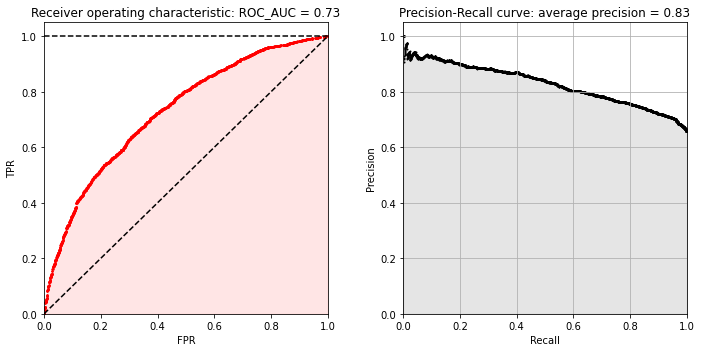

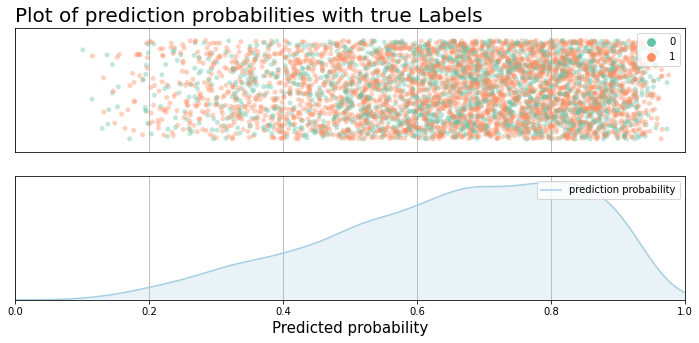

When recall is 75%, Precison is:  0.7669223074358119


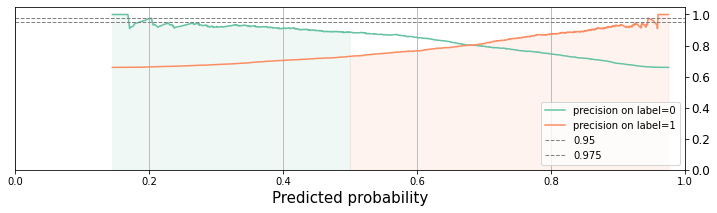

In [88]:
# evaluation metrics and visualization
X_test_1 = X_val_pca
y_test_1 = y_val.gender_M.values

y_pred_model = lr1.predict(X_test_1)
y_prob_model = lr1.predict_proba(X_test_1)[:,1]
# y_prob_model

model_evaluation(y_true=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=y_prob_model)
plot_prediction_probability(y_true=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=y_prob_model)
precision = precisionAnalysis(true_label=y_test_1, proba=y_prob_model, recall_at=0.75)
print("When recall is 75%, Precison is: ", precision)
plot_probability_calibration(y_true=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=y_prob_model)

**Explain on the result**
The evaluation metrics can be read directely from the classificaiton report, including accuracy, precision, recall and f1 score on both 0 and 1 class.
- The ROC curve is displayed. For ROC curve we usually care about the area under curve (AUC). Note that there is an diagonal line. I am afraid I cannot go to the details about ROC. Just remember, we desire an ROC curve above the diagonal line as much as possible which will gives us an maximum AUC ROC value of 1, while the diagonal line is associated with AUC ROC = 0.5.
- Precision-recall curve is also ploted. For this curve, we normally care about average precision and the precision at certain recall level, i.e. at 75% reacall.  

The performance of logistic regression model is not very good in this case. We were already expecting this since the data is not linearly seperatable.
- Among the accuracy is around 0.55, recall=0.60, and precision=0.57. Note that such metrics are calculated assuming the threshold is 0.5. note*
- ROC AUC is a 0.57, which we can see from the plot that ROC curve is just above the diagonal line. 
- The average precision is 0.57, and it is pretty flat across all the recall value, (most of the case, precision would drop when recall increase), with precision=0.56 when recall is 75%.

Next, I would like to introduce to you the predication probability strip plot. I found it very intuitive to show the distribution of predicted probablity with repective to the true label. This plot should be consistent with the conclusion drawn from ROC curve and precision-recall curve, but it also tells a story in more details about the predicted probability distribution, which can be helpful for making decision in proability calibration. i.e. we an pick up predictions that when we are very sure according to its prediction proability. I will explain this concept on the following machine learning models and the idea should be immediately clearer to you.

note*: some metrics might change due to I choose different sample size, but they should not be dramatically different. 

In [89]:
X_train_1 = X_train_pca
y_train_1 = y_train.gender_M.values

X_test_1 = X_val_pca
y_test_1 = y_val.gender_M.values



### SVM

In [90]:
# from sklearn.svm import SVC

# svc1 = SVC(random_state= RANDOM_STATE, probability=True)
# svc1.fit(X=X_train_1, y=y_train_1)
# y_pred_model = svc1.predict(X_test_1)
# # y_prob_model = svc1.predict_proba(X_test_1)[:,1]

# print("f1-score on training set: {}".format(f1_score(y_true=y_train_1, y_pred=svc1.predict(X_train_1))))
# print("f1-score on test set: {}".format(f1_score(y_true=y_test_1, y_pred=svc1.predict(X_test_1))))
'''
f1-score on training set: 0.8675963412805517
f1-score on test set: 0.8078989400319442
'''

'\nf1-score on training set: 0.8675963412805517\nf1-score on test set: 0.8078989400319442\n'

### KNN

In [91]:
# from sklearn.neighbors import KNeighborsClassifier

# knn1 = KNeighborsClassifier()
# knn1.fit(X=X_train_1, y=y_train_1)
# y_pred_model = knn1.predict(X_test_1)
# y_prob_model = knn1.predict_proba(X_test_1)[:,1]

# print("f1-score on training set: {}".format(f1_score(y_true=y_train_1, y_pred=knn1.predict(X_train_1))))
# print("f1-score on test set: {}".format(f1_score(y_true=y_test_1, y_pred=knn1.predict(X_test_1))))
'''
f1-score on training set: 0.8200031385677669
f1-score on test set: 0.7390769230769232
'''

'\nf1-score on training set: 0.8200031385677669\nf1-score on test set: 0.7390769230769232\n'

### naive bayes

In [92]:
from sklearn.naive_bayes import GaussianNB

gnb1 = GaussianNB()
gnb1.fit(X=X_train_1, y=y_train_1)
y_pred_model = gnb1.predict(X_test_1)
y_prob_model = gnb1.predict_proba(X_test_1)[:,1]

print("f1-score on training set: {}".format(f1_score(y_true=y_train_1, y_pred=gnb1.predict(X_train_1))))
print("f1-score on test set: {}".format(f1_score(y_true=y_test_1, y_pred=gnb1.predict(X_test_1))))

f1-score on training set: 0.6416246184513797
f1-score on test set: 0.6450055699962867


### random forest

In [93]:
from sklearn.ensemble import RandomForestClassifier

rfc1 = RandomForestClassifier(random_state= RANDOM_STATE)
rfc1.fit(X=X_train_1, y=y_train_1)
y_pred_model = rfc1.predict(X_test_1)
y_prob_model = rfc1.predict_proba(X_test_1)[:,1]

print("f1-score on training set: {}".format(f1_score(y_true=y_train_1, y_pred=rfc1.predict(X_train_1))))
print("f1-score on test set: {}".format(f1_score(y_true=y_test_1, y_pred=rfc1.predict(X_test_1))))

f1-score on training set: 1.0
f1-score on test set: 0.7985923118570656


classification_report
              precision    recall  f1-score   support

           0       0.66      0.14      0.23      1593
           1       0.68      0.96      0.80      3065

    accuracy                           0.68      4658
   macro avg       0.67      0.55      0.51      4658
weighted avg       0.67      0.68      0.60      4658



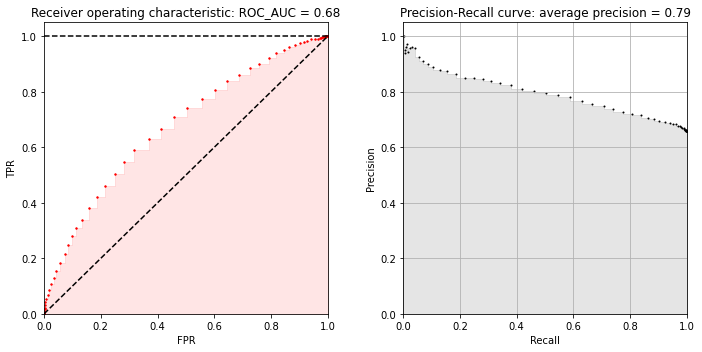

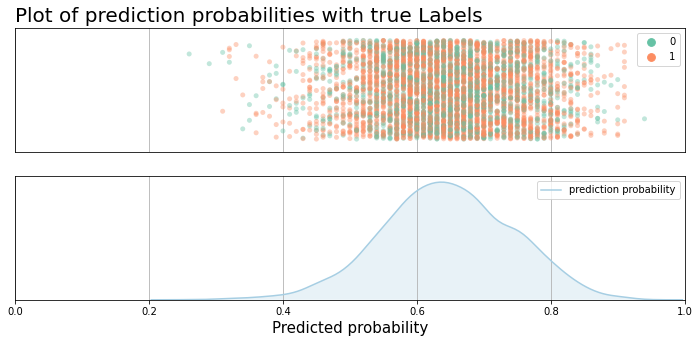

When recall is 75%, Precison is:  0.7331845712464138


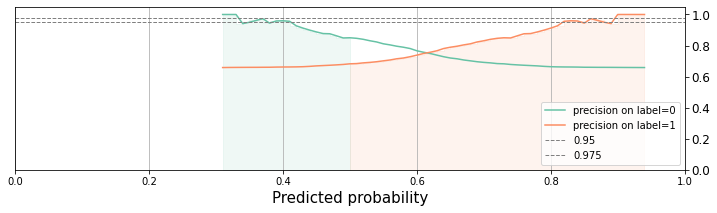

In [94]:
# evaluation metrics and visualization

y_pred_model = rfc1.predict(X_test_1)
y_prob_model = rfc1.predict_proba(X_test_1)[:,1]
# y_prob_model

model_evaluation(y_true=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=y_prob_model)
plot_prediction_probability(y_true=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=y_prob_model)
precision = precisionAnalysis(true_label=y_test_1, proba=y_prob_model, recall_at=0.75)
print("When recall is 75%, Precison is: ", precision)
plot_probability_calibration(y_true=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=y_prob_model)

**evaluation on random forest**
The performance has improved a lot, 
- accuracy, precision, f1 score are over 0.90, with recall a short of 0.89. Again, all these are associated with proability threshold==0.5.
- the AUC ROC and average precision is close to a full score. with AUC of ROC =0.97, average precision = 0.98.

Let's put our atttention to prediction proability stip plot. This time the predicted probability distribution is seperated on two side. With the actual labels color code with green=0, orange=1, you should realize that when an orage lable comes to the left side it indicates the model made a wrong prediction. (Here assuming the arbitrary threshold is set to 0.5).

Next, a good nature of many machine learning models is when it has a prediction value close to 1 or 0, pretty good chance that this prediction is correct. This phenomenon can be easily spot in the precision-probability plot (the last plot). i.e. when the predicted probability is over 0.8, the precion on label=1 is over 0.975, and when the predicted probability is less than 0.2, the precision on label=0 is also over 0.975. Actually it is very straightforward to see that as the predicted probability increase, the precision on label=1 also increase, on the other hand, when the predicted probability decrease, the precision on label=1 also increase. (Hopefully you see what I am doing now).

What I describe is the idea of probability calibration. Namely, we can cast away those predictions with value around 0.5, which can help to improve precision (at the cost of decrease of recall of course.). 

Note that if we throw away those prediction is within (0.2-0.8), the precision on both label=0 and lable=1 are above 0.975. Then how much element we have lost? We will lost 20% of the prediction. Since the logistic regression is too bad, for now just remember this number and we will compare the rest of the models.

notes* I drop the color to represent a more realistic condition, that is when you look at the predicted probaility distribution, there is no color to tell you the actual label. But this should not 

### XGBoost

In [95]:
from xgboost import XGBClassifier

xgbc = XGBClassifier(random_state=RANDOM_STATE)
xgbc.fit(X=X_train_1, y=y_train_1)
xgbc.get_params

print("f1-score on training set: {}".format(f1_score(y_true=y_train_1, y_pred=xgbc.predict(X_train_1))))
print("f1-score on test set: {}".format(f1_score(y_true=y_test_1, y_pred=xgbc.predict(X_test_1))))

f1-score on training set: 0.823529411764706
f1-score on test set: 0.7974647887323943


classification_report
              precision    recall  f1-score   support

           0       0.62      0.24      0.35      1593
           1       0.70      0.92      0.80      3065

    accuracy                           0.69      4658
   macro avg       0.66      0.58      0.57      4658
weighted avg       0.68      0.69      0.64      4658



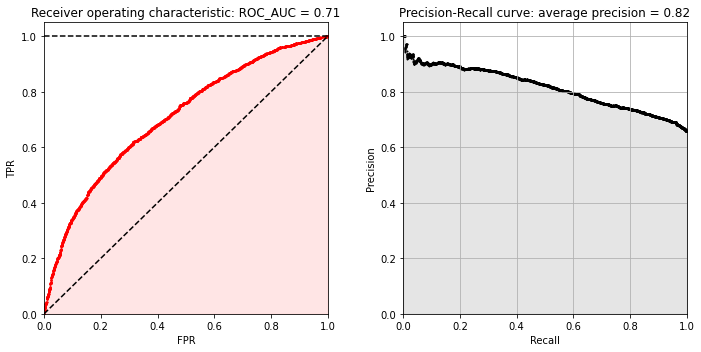

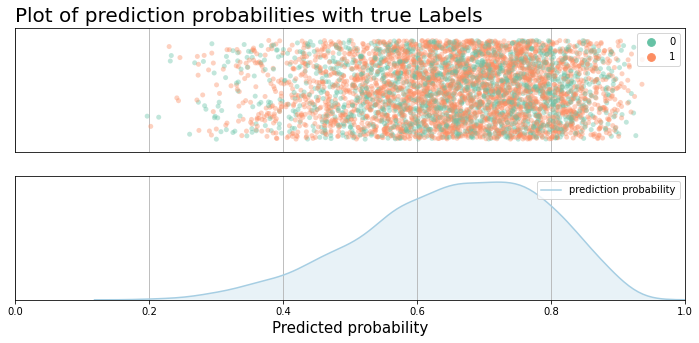

When recall is 75%, Precison is:  0.7508978126020242


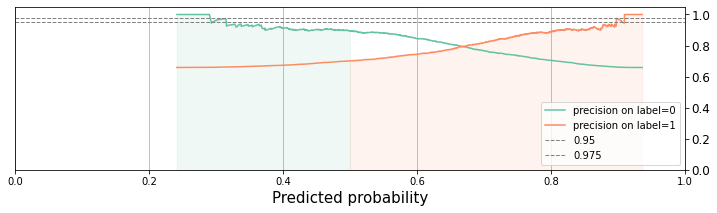

In [96]:
# evaluation metrics and visualization
y_pred_model = xgbc.predict(X_test_1)
y_prob_model = xgbc.predict_proba(X_test_1)[:,1]
# y_prob_model

model_evaluation(y_true=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=y_prob_model)
plot_prediction_probability(y_true=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=y_prob_model)
precision = precisionAnalysis(true_label=y_test_1, proba=y_prob_model, recall_at=0.75)
print("When recall is 75%, Precison is: ", precision)
plot_probability_calibration(y_true=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=y_prob_model)

sumary of XGBoost
I will save some words here but just talk about one thing. Remember the 20% prediction random forest cast away. What about XGBoost? This number is down to 13%. Wow, great improve.

From the classification report you can see that, even the metrics didn't seem better than the one of random forest. But when look into the predicted probability, we would realize the result from XGBoost is actually even better.

Let's move on to take a look at the last candidate. (Let me know if proability calibration doesn't make much sense to you)

### lightGBM

In [97]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=RANDOM_STATE)
lgbm.fit(X=X_train_1, y=y_train_1)
lgbm.get_params

print("f1-score on training set: {}".format(f1_score(y_true=y_train_1, y_pred=lgbm.predict(X_train_1))))
print("f1-score on test set: {}".format(f1_score(y_true=y_test_1, y_pred=lgbm.predict(X_test_1))))

f1-score on training set: 0.9153231958500737
f1-score on test set: 0.7898033503277495


classification_report
              precision    recall  f1-score   support

           0       0.59      0.32      0.41      1593
           1       0.71      0.88      0.79      3065

    accuracy                           0.69      4658
   macro avg       0.65      0.60      0.60      4658
weighted avg       0.67      0.69      0.66      4658



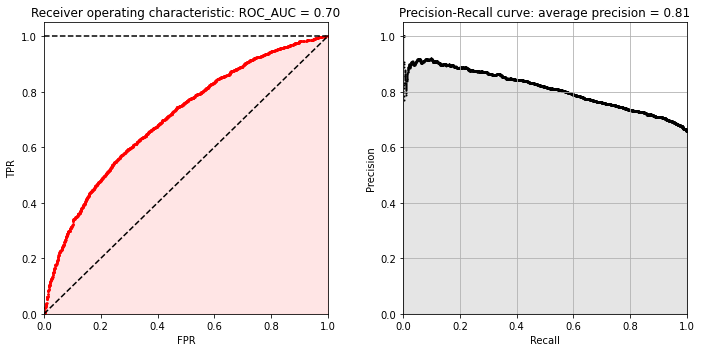

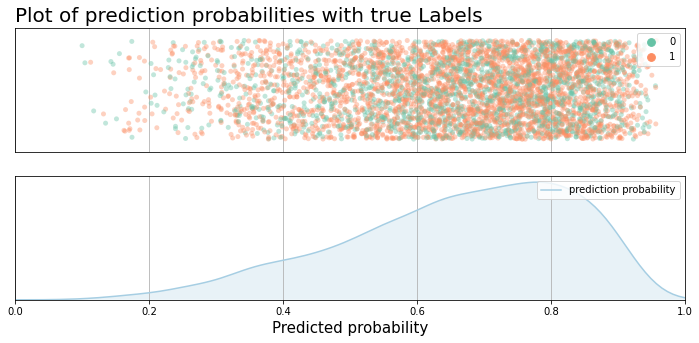

When recall is 75%, Precison is:  0.7486979166666666


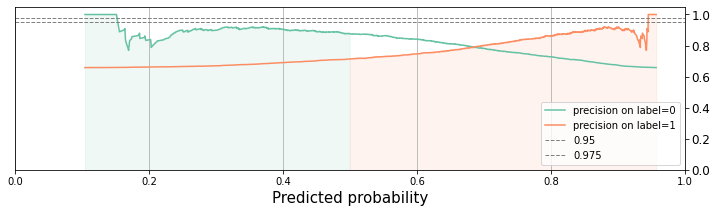

In [98]:
# evaluation metrics and visualization
y_pred_model = lgbm.predict(X_test_1)
y_prob_model = lgbm.predict_proba(X_test_1)[:,1]
# y_prob_model

model_evaluation(y_true=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=y_prob_model)
plot_prediction_probability(y_true=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=y_prob_model)
precision = precisionAnalysis(true_label=y_test_1, proba=y_prob_model, recall_at=0.75)
print("When recall is 75%, Precison is: ", precision)
plot_probability_calibration(y_true=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=y_prob_model)

In [99]:
# try to use the original data (no pca)

In [100]:
# from lightgbm import LGBMClassifier

lgbm_1 = LGBMClassifier(random_state=RANDOM_STATE)
lgbm_1.fit(X=X_train, y=y_train_1)
lgbm_1.get_params

print("f1-score on training set: {}".format(f1_score(y_true=y_train_1, y_pred=lgbm_1.predict(X_train))))
print("f1-score on validation set: {}".format(f1_score(y_true=y_test_1, y_pred=lgbm_1.predict(X_test))))

f1-score on training set: 0.8750187546886722
f1-score on validation set: 0.7248164464023494


### comments on the first-round trainings
this is a quick scan of the popular models. The goal is to find out the models that has the most potential so that we can further fine tune the parameters. From the test, we found that
- the models have best performancfes are SVM (supprisingly), randomForest, Xgboost, LightGBM
- data with pca is better than not

Note that even SVM has the best performance on validation set, the model itself has some drawbacks not suitable for application. (e.g. the computation speed is slow. e.g. SVM doesn't provide predictation probability, we cannot conduct probablity calibration.) So we would not choose it for further parameter fine-tuning.

## Fine-tune the models

### Grid search with cross validation
- grid search with cross validation short for gridsearchCV is a technology to fine-tune the model, a.k.a. hyper-parameter tuning.
- the grid search part define the searching space
- the cross-validation part is a way to fight overfitting

In [101]:
# Gridsearch CV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate':[  0.05, 0.1],
#     'n_estimators':[50, 100, 150],
    'n_estimators':[150],
    'max_depth' : [3, None],
    'min_samples_leaf': [ 8 ],
    'min_samples_split':[ 8 ],
    'max_features':[0.8,],
#     'max_features':[0.8, 0.9],
#     'max_depth': [ 3,  8, 12, ],
#     'min_samples_leaf': [ 4, 8, 16, ],
#     'min_samples_split':[ 2, 4, 8,],
#     'max_features':['auto', 0.9],
#     'tol': [1e-8, 1e-6,]
    
        
}
cv_num = 3
# Create a based model
xbg_grid = XGBClassifier()
# Instantiate the grid search model
grid_search_gbm2 = GridSearchCV(estimator = xbg_grid, param_grid = param_grid, 
                          cv = cv_num, 
                          scoring='f1',
                          n_jobs = -1, verbose = 1, )


# Fit the random search model
_ = grid_search_gbm2.fit(X_train_1, y_train_1)
print(grid_search_gbm2.best_score_)
print(grid_search_gbm2.best_estimator_.get_params)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   58.9s finished


0.7994995180239682
<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              max_features=0.8, min_child_weight=1, min_samples_leaf=8,
              min_samples_split=8, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)>


In [102]:
print("f1-score on training set: {}".format(f1_score(y_true=y_train_1, y_pred=grid_search_gbm2.predict(X_train_1))))
print("f1-score on test set: {}".format(f1_score(y_true=y_test_1, y_pred=grid_search_gbm2.predict(X_test_1))))

f1-score on training set: 0.8186046511627907
f1-score on test set: 0.7978324301792413


In [103]:
# there is 0.03 improve, this should be exciting

classification_report
              precision    recall  f1-score   support

           0       0.63      0.21      0.31      1593
           1       0.69      0.94      0.80      3065

    accuracy                           0.69      4658
   macro avg       0.66      0.57      0.56      4658
weighted avg       0.67      0.69      0.63      4658



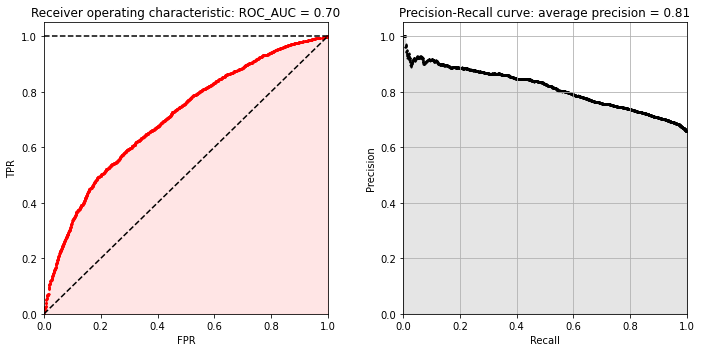

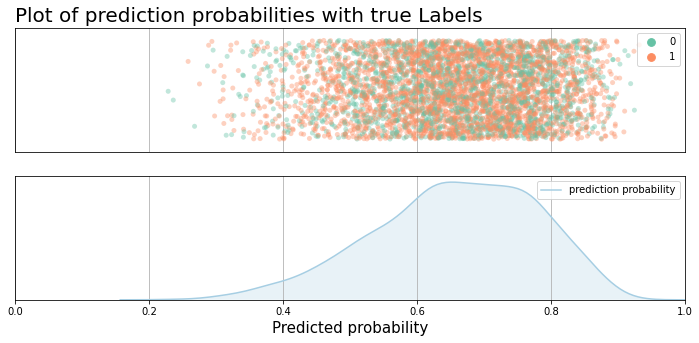

When recall is 75%, Precison is:  0.7474813129671758


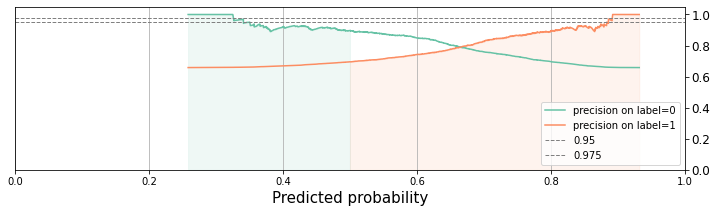

In [104]:
# evaluation metrics and visualization
y_pred_model = grid_search_gbm2.best_estimator_.predict(X_test_1)
y_prob_model = grid_search_gbm2.best_estimator_.predict_proba(X_test_1)[:,1]
# y_prob_model

model_evaluation(y_true=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=y_prob_model)
plot_prediction_probability(y_true=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=y_prob_model)
precision = precisionAnalysis(true_label=y_test_1, proba=y_prob_model, recall_at=0.75)
print("When recall is 75%, Precison is: ", precision)
plot_probability_calibration(y_true=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=y_prob_model)

### Random search with cross validation
- randomsearchCV is another way to fine tune hyper parameters.
- similar to gridsearchcv, randomsearchCV also needs to define a search space, and number of cv folds
- unlike, gridsearchCV, instead of searching all the hyper-parameters defined by the searching grid, randomsearchCV randomly choose hyper-parameters within the grid. That being said, we also need to specify the number of searching efforts.
- randomsearchCV is normally running much faster than gridsearchCV, since it doesn't scan all the grid. While it is true, randomsearchCV will miss part of the grid, it often covers the hyper-parameters that give good performance. Afterall, this is a trade-off between computation speed and covering more hyper-parameter candidates. (And I am on the side of randomsearch CV.)


In [105]:
# fine tune lightGBM, CHECK lightGBM's parameter name first

In [106]:
from sklearn.model_selection import RandomizedSearchCV

In [107]:
# Gridsearch CV
# from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate':[  0.05, 0.1],
    'n_estimators':[50, 100,],
    'max_depth' : [3, 10, 20, 40],
#     'min_samples_leaf': [ 8, 16,  ],
    'min_samples_split':[ 8 ],
    'max_features':[0.8, 0.9],
#     'max_depth': [ 3,  8, 12, ],
#     'min_samples_leaf': [ 4, 8, 16, ],
#     'min_samples_split':[ 2, 4, 8,],
#     'max_features':['auto', 0.9],
#     'tol': [1e-8, 1e-6,]
    
        
}
cv_num = 3
# Create a based model
lgbm_grid = LGBMClassifier(is_unbalance=True)
# Instantiate the grid search model
grid_search_lgbm = RandomizedSearchCV(estimator = lgbm_grid, param_distributions = param_grid, n_iter=30,
                          cv = cv_num, 
                          scoring='f1',
                          n_jobs = -1, verbose = 1, )


# Fit the random search model
_ = grid_search_lgbm.fit(X_train_1, y_train_1)
print(grid_search_lgbm.best_score_)
print(grid_search_lgbm.best_estimator_.get_params)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.1min finished


0.7375883976966967
<bound method LGBMModel.get_params of LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', is_unbalance=True, learning_rate=0.1,
               max_depth=10, max_features=0.8, min_child_samples=20,
               min_child_weight=0.001, min_samples_split=8, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)>


In [108]:
print("f1-score on training set: {}".format(f1_score(y_true=y_train_1, y_pred=grid_search_lgbm.predict(X_train_1))))
print("f1-score on test set: {}".format(f1_score(y_true=y_test_1, y_pred=grid_search_lgbm.predict(X_test_1))))

f1-score on training set: 0.9125085440874914
f1-score on test set: 0.7326631453399215


classification_report
              precision    recall  f1-score   support

           0       0.51      0.59      0.54      1593
           1       0.77      0.70      0.73      3065

    accuracy                           0.66      4658
   macro avg       0.64      0.65      0.64      4658
weighted avg       0.68      0.66      0.67      4658



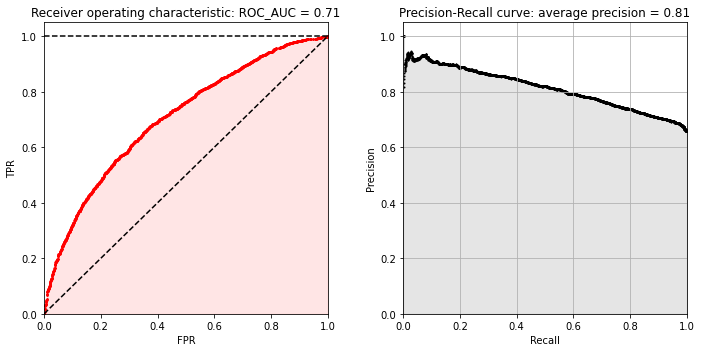

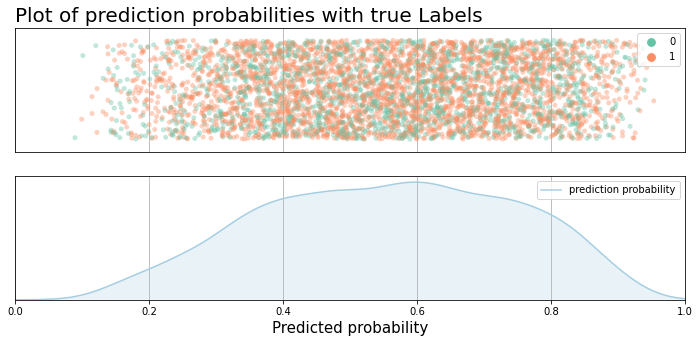

When recall is 75%, Precison is:  0.7494297816878462


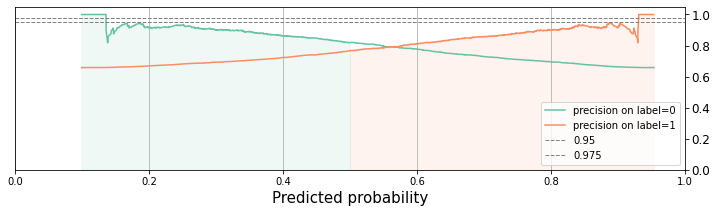

In [109]:
# evaluation metrics and visualization
y_pred_model = grid_search_lgbm.best_estimator_.predict(X_test_1)
y_prob_model = grid_search_lgbm.best_estimator_.predict_proba(X_test_1)[:,1]
# y_prob_model

model_evaluation(y_true=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=y_prob_model)
plot_prediction_probability(y_true=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=y_prob_model)
precision = precisionAnalysis(true_label=y_test_1, proba=y_prob_model, recall_at=0.75)
print("When recall is 75%, Precison is: ", precision)
plot_probability_calibration(y_true=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=y_prob_model)

### Summary and Notes
- parameter fine-tuning helped to increase f1 score by 0.03 for xgboost and 0.002 for lightgbm, respectively. 
- We should take into account the metrics and the computation time when using fine-tuning. (The trade-off mentioned earlier)


## Deep learning 
In this part, I will demonstrate how to use neural network to train the data. The main content include:
- How to build nerual networks using sklearn and tensorflow.
- How to fine-tune a NN model (number of layers, number of neurons, etc.)
- How to monitor the training process.
- How to fight overfitting.

**Notes**
- personally, I don't think the data is enough for deep learning. 
- but as part of the experiment, let's see how it would go.
- In another notebook, I will demonstrate how to train the unstructed app usage sequence data using CNN and RNN(LSTM), a more 'justfiable' application to use neural network. 
- spoiler alert: deep learning on unstructed data improved AUC-ROC for 0.06.
[**LINK HERE**](https://github.com/kefeimo/Thinkful_DataScience/blob/master/module38%20final%20capstone/NLP_pipeline_0817.ipynb)

### Neural networks in sklearn 
Build a multi-layer perceptron architecture.

In [110]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100,2,))
mlp.fit(X_train_1, y_train_1)

# lgbm.fit(X_train_1, y_train_1)
# print(lgbm.best_score_)
# print(grid_search_gbm5.best_estimator_.get_params)

print("f1-score on training set: {}".format(f1_score(y_true=y_train_1, y_pred=mlp.predict(X_train_1))))
print("f1-score on test set: {}".format(f1_score(y_true=y_test_1, y_pred=mlp.predict(X_test_1))))

f1-score on training set: 0.9789242590559825
f1-score on test set: 0.7198044009779953


In [111]:
mlp = MLPClassifier(hidden_layer_sizes=(50,2,))
mlp.fit(X_train_1, y_train_1)

# lgbm.fit(X_train_1, y_train_1)
# print(lgbm.best_score_)
# print(grid_search_gbm5.best_estimator_.get_params)

print("f1-score on training set: {}".format(f1_score(y_true=y_train_1, y_pred=mlp.predict(X_train_1))))
print("f1-score on test set: {}".format(f1_score(y_true=y_test_1, y_pred=mlp.predict(X_test_1))))

f1-score on training set: 0.9683186121542285
f1-score on test set: 0.7300721732157177


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


classification_report
              precision    recall  f1-score   support

           0       0.51      0.59      0.54      1593
           1       0.77      0.70      0.73      3065

    accuracy                           0.66      4658
   macro avg       0.64      0.65      0.64      4658
weighted avg       0.68      0.66      0.67      4658



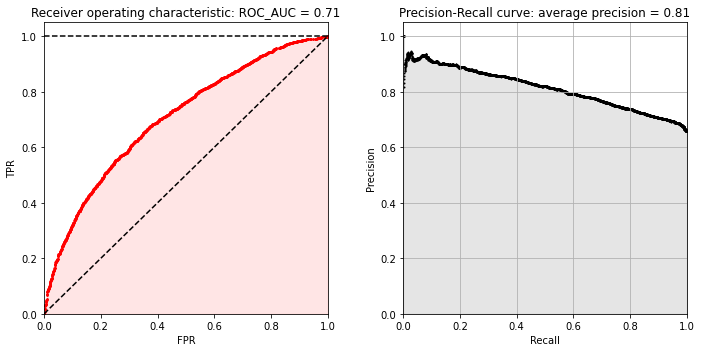

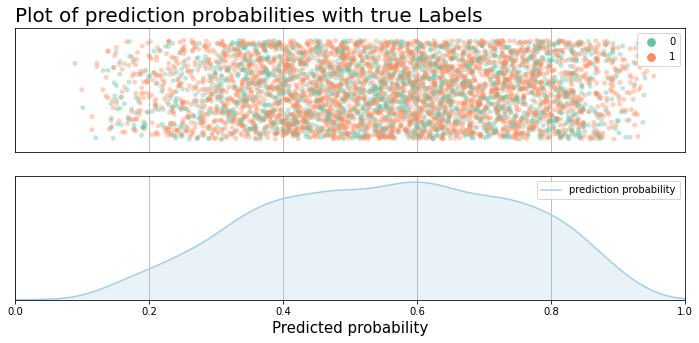

When recall is 75%, Precison is:  0.7494297816878462


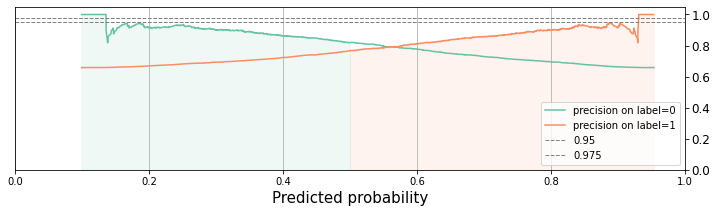

In [112]:
# evaluation metrics and visualization
y_pred_model = grid_search_lgbm.best_estimator_.predict(X_test_1)
y_prob_model = grid_search_lgbm.best_estimator_.predict_proba(X_test_1)[:,1]
# y_prob_model

model_evaluation(y_true=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=y_prob_model)
plot_prediction_probability(y_true=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=y_prob_model)
precision = precisionAnalysis(true_label=y_test_1, proba=y_prob_model, recall_at=0.75)
print("When recall is 75%, Precison is: ", precision)
plot_probability_calibration(y_true=y_test_1, y_pred=pd.DataFrame({'pred_yes':y_pred_model}), y_pred_prob=y_prob_model)

### Try TensorFlow

#### tf deep learning pipeline
- build NN (define architectures)
- train/fit (while record history)
- evaluation (anaylsis on the historical training record)
- adjust NN 

In [113]:
## try tensorflow
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense

In [114]:
# import tensorflow as tf

In [115]:
X_train_pca.shape

(13974, 150)

In [116]:
model_1 = Sequential()
# our first dense layer
model_1.add(Dense(32, input_shape=(150,), activation="relu"))
# our second dense layer
model_1.add(Dense(16, activation="relu"))
# last layer is the output layer.
model_1.add(Dense(2, activation="softmax"))

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                4832      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 5,394
Trainable params: 5,394
Non-trainable params: 0
_________________________________________________________________


In [117]:
model_1.compile(optimizer='sgd', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [118]:
batch_size = 20
epochs = 20
# setting verbose=1 prints out some results after each epoch
history = model_1.fit(X_train_pca, y_train_1, 
            validation_data=(X_test_pca, y_test_1),
            batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/20
699/699 [==============================] - 2s 2ms/step - loss: 0.6389 - accuracy: 0.6542 - val_loss: 0.6566 - val_accuracy: 0.6550
Epoch 2/20
699/699 [==============================] - 2s 2ms/step - loss: 0.6133 - accuracy: 0.6583 - val_loss: 0.6689 - val_accuracy: 0.6318
Epoch 3/20
699/699 [==============================] - 2s 2ms/step - loss: 0.6001 - accuracy: 0.6657 - val_loss: 0.6802 - val_accuracy: 0.6215
Epoch 4/20
699/699 [==============================] - 1s 2ms/step - loss: 0.5910 - accuracy: 0.6750 - val_loss: 0.6933 - val_accuracy: 0.6157
Epoch 5/20
699/699 [==============================] - 2s 2ms/step - loss: 0.5838 - accuracy: 0.6861 - val_loss: 0.7040 - val_accuracy: 0.6116
Epoch 6/20
699/699 [==============================] - 2s 2ms/step - loss: 0.5787 - accuracy: 0.6956 - val_loss: 0.7114 - val_accuracy: 0.5990
Epoch 7/20
699/699 [==============================] - 2s 2ms/step - loss: 0.5750 - accuracy: 0.6977 - val_loss: 0.7177 - val_accuracy: 0.5942
Epoch 

In [119]:
score_1 = model_1.evaluate(X_test_pca, y_test_1, verbose=0)
print('Test score:', score_1[0])
print('Test accuracy:', score_1[1])

Test score: 0.7367972135543823
Test accuracy: 0.5863031148910522


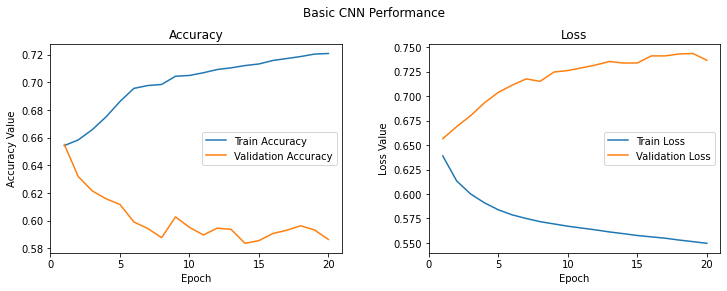

In [120]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
try:
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
except:
    ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

**Comments**

kinda bad!!
apparently there is already some overfitting happened. We don't even have to try more sophiscated architecture. But just for experiment, let's see if it works.

#### Play with NN (Change architecture)

In [121]:
model_2 = Sequential()
# our first dense layer (with input layer)
model_2.add(Dense(1024, input_shape=(150,), activation="relu"))
# our second dense layer
model_2.add(Dense(512, activation="relu"))
# our third dense layer
model_2.add(Dense(256, activation="relu"))
# our fourth dense layer
model_2.add(Dense(128, activation="relu"))
# our fifth dense layer
model_2.add(Dense(64, activation="relu"))
# last layer is the output layer.
model_2.add(Dense(2, activation="softmax"))

In [122]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              154624    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 130       
Total params: 852,034
Trainable params: 852,034
Non-trainable params: 0
________________________________________________

In [123]:
model_2.compile(optimizer='sgd', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [124]:
batch_size = 20
epochs = 20
# setting verbose=1 prints out some results after each epoch
history = model_2.fit(X_train_pca, y_train_1, 
            validation_data=(X_test_pca, y_test_1),
            batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/20
699/699 [==============================] - 2s 3ms/step - loss: 0.6340 - accuracy: 0.6512 - val_loss: 0.6523 - val_accuracy: 0.6541
Epoch 2/20
699/699 [==============================] - 2s 2ms/step - loss: 0.5954 - accuracy: 0.6763 - val_loss: 0.6887 - val_accuracy: 0.6303
Epoch 3/20
699/699 [==============================] - 2s 2ms/step - loss: 0.5716 - accuracy: 0.7016 - val_loss: 0.7167 - val_accuracy: 0.5964
Epoch 4/20
699/699 [==============================] - 2s 2ms/step - loss: 0.5592 - accuracy: 0.7133 - val_loss: 0.7299 - val_accuracy: 0.6052
Epoch 5/20
699/699 [==============================] - 2s 2ms/step - loss: 0.5471 - accuracy: 0.7224 - val_loss: 0.7414 - val_accuracy: 0.5788
Epoch 6/20
699/699 [==============================] - 2s 2ms/step - loss: 0.5351 - accuracy: 0.7333 - val_loss: 0.7528 - val_accuracy: 0.5661
Epoch 7/20
699/699 [==============================] - 2s 2ms/step - loss: 0.5202 - accuracy: 0.7435 - val_loss: 0.7779 - val_accuracy: 0.5936
Epoch 

In [125]:
score_2 = model_2.evaluate(X_test_pca, y_test_1, verbose=0)
print('Test score:', score_1[0])
print('Test accuracy:', score_1[1])

Test score: 0.7367972135543823
Test accuracy: 0.5863031148910522


## Summary on binary classification task
- We 've walked through the ML pipeline from choosing model to evaulation. Surprisingly (and sadly) the best performance model for this task is using logistic regress (lr2).
- We also tried using nerual network to train on the data. When trying more sophiscated architecture, the result is even worse, because it is overfitted. As expected neural network is not very suitable for this pca-processed dataset.
- once again, check my another notebook that showcase a more suitable application of deep learning for this project. [**LINK HERE**](https://github.com/kefeimo/Thinkful_DataScience/blob/master/module38%20final%20capstone/NLP_pipeline_0817.ipynb)

## multi-class target
- Earlier I demonstrated solving a binary classfication task. Now let's take a look of muli-class classification. 
- For this part of work, we will try to classify user groups into three age groups, ['A26-', 'A27-31', 'A32+'].
- The pipeline of multi-classsfication problem is actually very similar to binary classification. We will go through choosing models, training, evaluation, model fine-tune again.

In [126]:
from sklearn.metrics import label_ranking_average_precision_score

In [127]:
from sklearn.preprocessing import LabelEncoder
le_age_cate = LabelEncoder()
y_age_cate = le_age_cate.fit_transform(df_original['age_cate_new'])
le_age_cate.classes_

array(['A26-', 'A27-31', 'A32+'], dtype=object)

In [128]:
y_train_2, y_test_2 = train_test_split(y_age_cate, test_size=2/10, random_state=RANDOM_STATE)
y_train_2, y_val_2 = train_test_split(y_train_2, test_size=2/8, random_state=RANDOM_STATE)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2/10, random_state=RANDOM_STATE)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=2/8, random_state=RANDOM_STATE)


In [129]:
# train with the default model
from sklearn.linear_model import LogisticRegression

lr2 = LogisticRegression(   
    max_iter=1e4,     
    random_state= RANDOM_STATE, 
    multi_class='multinomial',) 
lr2.fit(X=X_train_pca, y=y_train_2)
lr2.get_params

print("accuracy on training set: {}".format(accuracy_score(y_true=y_train_2, y_pred=lr2.predict(X_train_pca))))
print("accuracy on validation set: {}".format(accuracy_score(y_true=y_val_2, y_pred=lr2.predict(X_val_pca))))

accuracy on training set: 0.5451552883927293
accuracy on validation set: 0.5337054529841133


In [130]:
print(classification_report(y_true=y_val_2, y_pred=lr2.predict(X_val_pca)))

              precision    recall  f1-score   support

           0       0.52      0.62      0.57      1385
           1       0.39      0.15      0.21      1303
           2       0.57      0.73      0.64      1970

    accuracy                           0.53      4658
   macro avg       0.49      0.50      0.47      4658
weighted avg       0.51      0.53      0.50      4658



In [131]:
# print("average-precision on training set: {}".format(label_ranking_average_precision_score(y_true=y_train_2, y_score=lr2.predict(X_train_pca))))
# print("average-precision on validation set: {}".format(label_ranking_average_precision_score(y_true=y_val_2, y_score=lr2.predict(X_val_pca))))

In [132]:
# try random forest

In [133]:
# from sklearn.ensemble import RandomForestClassifier

rfc2 = RandomForestClassifier(random_state= RANDOM_STATE)
rfc2.fit(X=X_train_1, y=y_train_2)
y_pred_model = rfc2.predict(X_test_1)
y_prob_model = rfc2.predict_proba(X_test_1)[:,1]

print("accuracy on training set: {}".format(accuracy_score(y_true=y_train_2, y_pred=rfc2.predict(X_train_1))))
print("accuracy on test set: {}".format(accuracy_score(y_true=y_test_2, y_pred=rfc2.predict(X_test_1))))

accuracy on training set: 1.0
accuracy on test set: 0.36839845427221984


In [134]:
# try xgboost

In [135]:
xgbc2 = XGBClassifier(random_state=RANDOM_STATE, )
xgbc2.fit(X=X_train_1, y=y_train_2)
# xgbc2.get_params

print("accuracy on training set: {}".format(accuracy_score(y_true=y_train_2, y_pred=xgbc2.predict(X_train_1))))
print("accuracy on test set: {}".format(accuracy_score(y_true=y_test_2, y_pred=xgbc2.predict(X_test_1))))

accuracy on training set: 0.58587376556462
accuracy on test set: 0.3707599828252469


In [136]:
# try lightGBM

In [137]:
lgbm2 = LGBMClassifier(random_state=RANDOM_STATE, )
lgbm2.fit(X=X_train_1, y=y_train_2)
# xgbc2.get_params

print("accuracy on training set: {}".format(accuracy_score(y_true=y_train_2, y_pred=lgbm2.predict(X_train_1))))
print("accuracy on test set: {}".format(accuracy_score(y_true=y_test_2, y_pred=lgbm2.predict(X_test_1))))

accuracy on training set: 0.8307571203663947
accuracy on test set: 0.36582224130528124


In [138]:
# try gridCV again

In [139]:
# Gridsearch CV
# from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate':[  0.05, 0.1],
    'n_estimators':[50, 100, 150],
    'max_depth' : [10, -1],
    'min_child_samples': [ 8,20 ],
#     'min_samples_split':[ 8 ],
    'num_leaves':[10, 20, 30, ],
#     'max_depth': [ 3,  8, 12, ],
#     'min_samples_leaf': [ 4, 8, 16, ],
#     'min_samples_split':[ 2, 4, 8,],
#     'max_features':['auto', 0.9],
#     'tol': [1e-8, 1e-6,]
    
        
}
cv_num = 3
# Create a based model
lgbm_grid = LGBMClassifier()
# Instantiate the grid search model
# grid_search_lgbm2 = GridSearchCV(estimator = lgbm_grid, param_grid = param_grid, 
#                           cv = cv_num, 
#                           scoring='accuracy',
#                           n_jobs = -1, verbose = 1, )
grid_search_lgbm2 = RandomizedSearchCV(estimator = lgbm_grid, param_distributions = param_grid, n_iter=30,
                          cv = cv_num, 
                          scoring='accuracy',
                          n_jobs = -1, verbose = 1, )

# Fit the random search model
_ = grid_search_lgbm2.fit(X_train_1, y_train_2)
# print(grid_search_lgbm2.best_score_)
# print(grid_search_lgbm2.best_estimator_.get_params)



Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 10.1min finished


In [140]:
print("accuracy on training set: {}".format(accuracy_score(y_true=y_train_2, y_pred=grid_search_lgbm.best_estimator_.predict(X_train_1))))
print("accuracy on test set: {}".format(accuracy_score(y_true=y_test_2, y_pred=grid_search_lgbm.best_estimator_.predict(X_test_1))))

accuracy on training set: 0.2971947903248891
accuracy on test set: 0.28595963933018465


In [141]:
# try MLP

In [142]:
model_3 = Sequential()
# our first dense layer
model_3.add(Dense(32, input_shape=(150,), activation="relu"))
# our second dense layer
model_3.add(Dense(16, activation="relu"))
# last layer is the output layer.
model_3.add(Dense(6, activation="softmax"))

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                4832      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 102       
Total params: 5,462
Trainable params: 5,462
Non-trainable params: 0
_________________________________________________________________


In [143]:
model_3.compile(optimizer='sgd', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [144]:
atch_size = 20
epochs = 20
# setting verbose=1 prints out some results after each epoch
history = model_3.fit(X_train_pca, y_train_2, 
            validation_data=(X_test_pca, y_test_2),
            batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/20
699/699 [==============================] - 2s 2ms/step - loss: 1.2940 - accuracy: 0.4229 - val_loss: 1.0804 - val_accuracy: 0.4672
Epoch 2/20
699/699 [==============================] - 1s 2ms/step - loss: 1.0442 - accuracy: 0.4902 - val_loss: 1.0255 - val_accuracy: 0.4854
Epoch 3/20
699/699 [==============================] - 2s 2ms/step - loss: 1.0071 - accuracy: 0.5079 - val_loss: 1.0067 - val_accuracy: 0.5011
Epoch 4/20
699/699 [==============================] - 2s 2ms/step - loss: 0.9899 - accuracy: 0.5157 - val_loss: 0.9976 - val_accuracy: 0.5045
Epoch 5/20
699/699 [==============================] - 1s 2ms/step - loss: 0.9801 - accuracy: 0.5204 - val_loss: 0.9929 - val_accuracy: 0.5090
Epoch 6/20
699/699 [==============================] - 1s 2ms/step - loss: 0.9739 - accuracy: 0.5263 - val_loss: 0.9917 - val_accuracy: 0.5092
Epoch 7/20
699/699 [==============================] - 2s 2ms/step - loss: 0.9693 - accuracy: 0.5281 - val_loss: 0.9881 - val_accuracy: 0.5204
Epoch 

In [145]:
y_pred = pd.DataFrame(model_3.predict(X_train_pca)).apply(lambda x: x.argmax(), axis=1).values
print(classification_report(y_true=y_train_2, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.53      0.67      0.59      4381
           1       0.46      0.15      0.22      3841
           2       0.59      0.74      0.66      5752

    accuracy                           0.56     13974
   macro avg       0.53      0.52      0.49     13974
weighted avg       0.54      0.56      0.52     13974



In [146]:
y_pred = pd.DataFrame(model_3.predict(X_val_pca)).apply(lambda x: x.argmax(), axis=1).values
print(classification_report(y_true=y_val_2, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.49      0.64      0.56      1385
           1       0.37      0.11      0.17      1303
           2       0.56      0.70      0.62      1970

    accuracy                           0.52      4658
   macro avg       0.47      0.48      0.45      4658
weighted avg       0.49      0.52      0.48      4658



In [147]:
# this is promising, let's try to make more layers

In [148]:
model_4 = Sequential()
# our first dense layer (with input layer)
model_4.add(Dense(1024, input_shape=(150,), activation="relu"))
# our second dense layer
model_4.add(Dense(512, activation="relu"))
# our third dense layer
model_4.add(Dense(256, activation="relu"))
# our fourth dense layer
model_4.add(Dense(128, activation="relu"))
# our fifth dense layer
model_4.add(Dense(64, activation="relu"))
# last layer is the output layer.
model_4.add(Dense(6, activation="softmax"))



In [149]:
model_4.compile(optimizer='sgd', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [150]:
batch_size = 20
epochs = 20
# setting verbose=1 prints out some results after each epoch
history = model_4.fit(X_train_pca, y_train_2, 
            validation_data=(X_test_pca, y_test_2),
            batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/20
699/699 [==============================] - 2s 3ms/step - loss: 1.1567 - accuracy: 0.4454 - val_loss: 1.0104 - val_accuracy: 0.4976
Epoch 2/20
699/699 [==============================] - 2s 3ms/step - loss: 0.9935 - accuracy: 0.5102 - val_loss: 0.9851 - val_accuracy: 0.5178
Epoch 3/20
699/699 [==============================] - 2s 2ms/step - loss: 0.9719 - accuracy: 0.5269 - val_loss: 0.9849 - val_accuracy: 0.5159
Epoch 4/20
699/699 [==============================] - 2s 2ms/step - loss: 0.9588 - accuracy: 0.5352 - val_loss: 0.9900 - val_accuracy: 0.5170
Epoch 5/20
699/699 [==============================] - 2s 2ms/step - loss: 0.9480 - accuracy: 0.5464 - val_loss: 0.9971 - val_accuracy: 0.5144
Epoch 6/20
699/699 [==============================] - 2s 2ms/step - loss: 0.9372 - accuracy: 0.5530 - val_loss: 0.9804 - val_accuracy: 0.5225
Epoch 7/20
699/699 [==============================] - 2s 2ms/step - loss: 0.9202 - accuracy: 0.5678 - val_loss: 1.0057 - val_accuracy: 0.4923
Epoch 

In [151]:
y_pred = pd.DataFrame(model_4.predict(X_val_pca)).apply(lambda x: x.argmax(), axis=1).values
print(classification_report(y_true=y_val_2, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.47      0.50      0.49      1385
           1       0.31      0.23      0.26      1303
           2       0.54      0.60      0.57      1970

    accuracy                           0.47      4658
   macro avg       0.44      0.44      0.44      4658
weighted avg       0.45      0.47      0.46      4658



### Intermediate summary on multi-classification task.
- when the number of target class increase, the learning become harder.
- since the age group is some how ordinal, we should take a advantage of that.
- later on, we will tacle a related task but a regression one.

### let's try onevsRest

In [152]:
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(estimator = LGBMClassifier(), n_jobs=-1)

clf.fit(X_train_pca, y_train_2)

print("accuracy on training set: {}".format(accuracy_score(y_true=y_train_2, y_pred=clf.predict(X_train_pca))))
print("accuracy on validation set: {}".format(accuracy_score(y_true=y_val_2, y_pred=clf.predict(X_val_pca))))

accuracy on training set: 0.8817088879347359
accuracy on validation set: 0.5135251180764276


### would gridCV helps?
oneVsRest esitmator help to improve accuracy, but let's go further.

### note: in order to use OneVsRestClassifier inside gridSearchCV, the param_grid need to modeifed to add ''estimator__' in front. e.g. 'estimator__learning_rate' vs. 'learning_rate'

In [153]:
# Gridsearch CV
# from sklearn.model_selection import GridSearchCV

param_grid = {
    'estimator__learning_rate':[  0.05, 0.1],
    'estimator__n_estimators':[50, 100, 150],
    'estimator__max_depth' : [3, 20, None],
    'estimator__min_samples_leaf': [ 8 ],
    'estimator__min_samples_split':[ 8 ],
    'estimator__max_features':[0.8, 0.9],
#     'max_depth': [ 3,  8, 12, ],
#     'min_samples_leaf': [ 4, 8, 16, ],
#     'min_samples_split':[ 2, 4, 8,],
#     'max_features':['auto', 0.9],
#     'tol': [1e-8, 1e-6,]
    
        
}
cv_num = 3
# Create a based model
clf = OneVsRestClassifier(estimator = LGBMClassifier(), n_jobs=-1)
# Instantiate the grid search model
# grid_search_lgbm3 = GridSearchCV(estimator = clf, param_grid = param_grid, 
#                           cv = cv_num, 
#                           scoring='accuracy',
#                           n_jobs = -1, verbose = 1, )
grid_search_lgbm3 = RandomizedSearchCV(estimator = clf, param_distributions = param_grid, n_iter=30,
                          cv = cv_num, 
                          scoring='accuracy',
                          n_jobs = -1, verbose = 1, )


# Fit the random search model
_ = grid_search_lgbm3.fit(X_train_1, y_train_2)
# print(grid_search_lgbm2.best_score_)
# print(grid_search_lgbm2.best_estimator_.get_params)

print("accuracy on training set: {}".format(accuracy_score(y_true=y_train_2, y_pred=grid_search_lgbm3.best_estimator_.predict(X_train_pca))))
print("accuracy on validation set: {}".format(accuracy_score(y_true=y_val_2, y_pred=grid_search_lgbm3.best_estimator_.predict(X_val_pca))))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 11.6min finished


accuracy on training set: 0.7501789036782597
accuracy on validation set: 0.5206097037355089


In [154]:
print("accuracy on training set: {}".format(accuracy_score(y_true=y_train_2, y_pred=grid_search_lgbm3.best_estimator_.predict(X_train_pca))))
print("accuracy on validation set: {}".format(accuracy_score(y_true=y_val_2, y_pred=grid_search_lgbm3.best_estimator_.predict(X_val_pca))))

accuracy on training set: 0.7501789036782597
accuracy on validation set: 0.5206097037355089


In [155]:
print(classification_report(y_true=y_train_2, y_pred=grid_search_lgbm3.best_estimator_.predict(X_train_pca)))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      4381
           1       0.98      0.47      0.63      3841
           2       0.69      0.91      0.79      5752

    accuracy                           0.75     13974
   macro avg       0.81      0.72      0.73     13974
weighted avg       0.79      0.75      0.74     13974



In [156]:
print(classification_report(y_true=y_val_2, y_pred=grid_search_lgbm3.best_estimator_.predict(X_val_pca)))

              precision    recall  f1-score   support

           0       0.51      0.61      0.55      1385
           1       0.34      0.07      0.11      1303
           2       0.55      0.76      0.64      1970

    accuracy                           0.52      4658
   macro avg       0.46      0.48      0.43      4658
weighted avg       0.48      0.52      0.46      4658



In [157]:
print(classification_report(y_true=y_test_2, y_pred=grid_search_lgbm3.best_estimator_.predict(X_test_pca)))

              precision    recall  f1-score   support

           0       0.50      0.59      0.54      1410
           1       0.39      0.07      0.12      1306
           2       0.54      0.77      0.64      1942

    accuracy                           0.52      4658
   macro avg       0.48      0.48      0.43      4658
weighted avg       0.49      0.52      0.46      4658



In [158]:
# end of multi-class classification task

## regression task
As the last piece of the supervised learning demonstration, let's take a look of regression task, i.e. predict user age.

In [159]:
y_train_regr = Y_train.age.values
y_val_regr = Y_val.age.values
y_test_regr = Y_test.age.values

In [160]:
from sklearn.metrics import mean_squared_error, r2_score

In [161]:
# linear regression

In [162]:
from sklearn.linear_model import LinearRegression

lr_r = LinearRegression(   
#     max_iter=1e4,     
#     random_state= RANDOM_STATE, 
    ) 
lr_r.fit(X=X_train_pca, y=y_train_regr)
lr_r.get_params

print("MSE on training set: {}".format(mean_squared_error(y_true=y_train_regr, y_pred=lr_r.predict(X_train_pca))))
print("MSE on validation set: {}".format(mean_squared_error(y_true=y_val_regr, y_pred=lr_r.predict(X_val_pca))))

print("r2 on training set: {}".format(r2_score(y_true=y_train_regr, y_pred=lr_r.predict(X_train_pca))))
print("r2 on validation set: {}".format(r2_score(y_true=y_val_regr, y_pred=lr_r.predict(X_val_pca))))

MSE on training set: 77.54062363644614
MSE on validation set: 76.90746946491234
r2 on training set: 0.20284781188099854
r2 on validation set: 0.20350304857199586


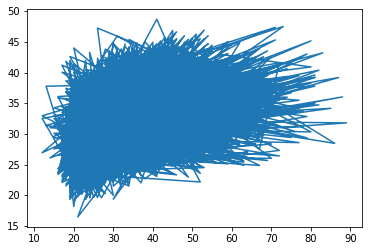

In [163]:
plt.plot(y_train_regr, lr_r.predict(X_train_pca))

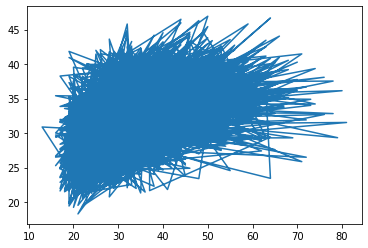

In [164]:
plt.plot(y_val_regr, lr_r.predict(X_val_pca))

In [165]:
## try lightgbm

In [166]:
from lightgbm import LGBMRegressor

lgbm_r = LGBMRegressor(   
#     max_iter=1e4,     
#     random_state= RANDOM_STATE, 
    ) 
lgbm_r.fit(X=X_train_pca, y=y_train_regr)
lgbm_r.get_params

print("MSE on training set: {}".format(mean_squared_error(y_true=y_train_regr, y_pred=lgbm_r.predict(X_train_pca))))
print("MSE on validation set: {}".format(mean_squared_error(y_true=y_val_regr, y_pred=lgbm_r.predict(X_val_pca))))

print("r2 on training set: {}".format(r2_score(y_true=y_train_regr, y_pred=lgbm_r.predict(X_train_pca))))
print("r2 on validation set: {}".format(r2_score(y_true=y_val_regr, y_pred=lgbm_r.predict(X_val_pca))))

MSE on training set: 43.44262376653906
MSE on validation set: 79.7592538008936
r2 on training set: 0.5533904556211235
r2 on validation set: 0.1739683681886358


In [167]:
lgbm_r.get_params


<bound method LGBMModel.get_params of LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)>

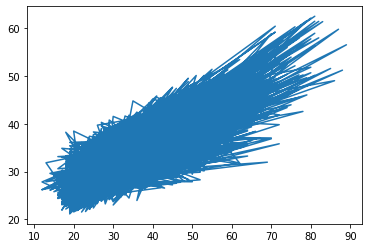

In [168]:
plt.plot(y_train_regr, lgbm_r.predict(X_train_pca))



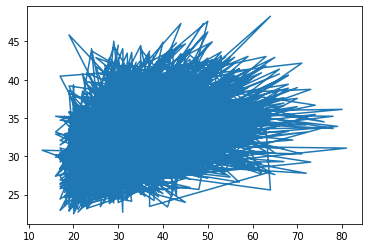

In [169]:
plt.plot(y_val_regr, lgbm_r.predict(X_val_pca))

In [170]:
# Gridsearch CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {
    'learning_rate':[  0.05, 0.1],
    'n_estimators':[50, 100,],
    'max_depth' : [3, 10, 20, 40],
#     'min_samples_leaf': [ 8, 16,  ],
    'min_samples_split':[ 8 ],
    'max_features':[0.8, 0.9],
#     'max_depth': [ 3,  8, 12, ],
#     'min_samples_leaf': [ 4, 8, 16, ],
#     'min_samples_split':[ 2, 4, 8,],
#     'max_features':['auto', 0.9],
#     'tol': [1e-8, 1e-6,]
    
        
}
cv_num = 5
# Create a based model
lgbm_grid = LGBMRegressor()
# Instantiate the grid search model
grid_search_lgbm_r = RandomizedSearchCV(estimator = lgbm_grid, param_distributions = param_grid, n_iter=30,
                          cv = cv_num, 
#                           scoring='l2',
                          n_jobs = -1, verbose = 1, )


# Fit the random search model
_ = grid_search_lgbm_r.fit(X_train_pca, y_train_regr)
print("MSE on training set: {}".format(mean_squared_error(y_true=y_train_regr, y_pred=grid_search_lgbm_r.predict(X_train_pca))))
print("MSE on validation set: {}".format(mean_squared_error(y_true=y_val_regr, y_pred=grid_search_lgbm_r.predict(X_val_pca))))

print("r2 on training set: {}".format(r2_score(y_true=y_train_regr, y_pred=grid_search_lgbm_r.predict(X_train_pca))))
print("r2 on validation set: {}".format(r2_score(y_true=y_val_regr, y_pred=grid_search_lgbm_r.predict(X_val_pca))))



Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  5.4min finished


MSE on training set: 57.97101256266997
MSE on validation set: 79.86285566174436
r2 on training set: 0.4040321402562751
r2 on validation set: 0.17289540912621937


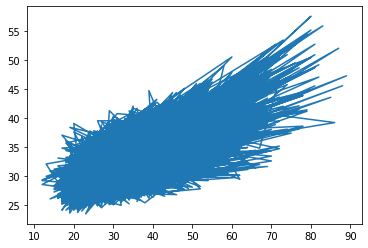

In [171]:
plt.plot(y_train_regr, grid_search_lgbm_r.predict(X_train_pca))

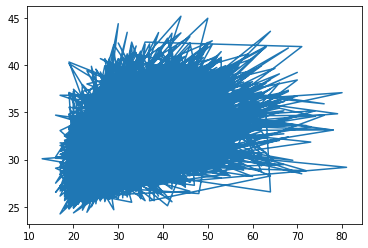

In [172]:
plt.plot(y_val_regr, grid_search_lgbm_r.predict(X_val_pca))

### Comments
The result is very bad. I didn't find any model that suitable for the regression task.

In [173]:
# End of supervised learning

## Performance summary
(binary classification)

In [174]:
from sklearn.metrics import roc_auc_score, f1_score

In [175]:
model_bi_list = [lr1, gnb1, rfc1, xgbc, lgbm, grid_search_gbm2, grid_search_lgbm]
performance_summary_bi = pd.DataFrame({'model_bi_instance':model_bi_list})
performance_summary_bi['description'] = ['logistic regression', 'GaussianNB', 'RandomForest', 'XGBoost', 'LightGBM', 'XGBoost-fine-tuned', 'LightGBM-fine-tuned']

In [176]:
performance_summary_bi['roc_auc'] = performance_summary_bi.model_bi_instance.apply(lambda x: roc_auc_score(y_true=y_test_1, y_score=x.predict_proba(X_test_1)[:,1]))
performance_summary_bi['f1'] = performance_summary_bi.model_bi_instance.apply(lambda x: f1_score(y_true=y_test_1, y_pred=x.predict(X_test_1)))

performance_summary_bi

,model_bi_instance,description,roc_auc,f1
0,"LogisticRegression(C=1.0, class_weight=None, d...",logistic regression,0.729906,0.796439
1,"GaussianNB(priors=None, var_smoothing=1e-09)",GaussianNB,0.631805,0.645006
2,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",RandomForest,0.679816,0.798592
3,"XGBClassifier(base_score=0.5, booster='gbtree'...",XGBoost,0.706595,0.797465
4,"LGBMClassifier(boosting_type='gbdt', class_wei...",LightGBM,0.703768,0.789803
5,"GridSearchCV(cv=3, error_score=nan,\n ...",XGBoost-fine-tuned,0.704558,0.797832
6,"RandomizedSearchCV(cv=3, error_score=nan,\n ...",LightGBM-fine-tuned,0.705478,0.732663


# Post trining analysis 
## Recap
It has been a while when first start this project walk-through, let's first have some recap.
- Project purpose: The project is to predict user demographics using cellphone data. This is important becasue the result can be used for taget advertising or other application rely on customer profile.
- Method: build machine learning models for the classification task.
- Result: For the binary classification task, lr1 model got roc-auc=0.73, f1=0.79, grid_search_gbm2 got roc-auc=0.70, f1=0.7978, grid_search_lgbm=0.71, f1=0.7326. This is far from impressive.

## How to improve? 

### Get more data (almost always works)
- Recall that the median number of event is 15, 75 percentile of the number of events is 50. I suspected that this is not enough for most of the ML model to learn. In other words, for each iterm associated with users, there might be a lot of noise. 
- The following plot trys to illustrate the relationship between number of event count and performance (indicated by log_loss: the lower the log_loss score the better the performance). 
- From the plot (looks like a bumerrang according to the kde plot), we can see that most of the high log_loss value happend when the number of event count is low, while there is almost no high log_loss value when the number of event count is high. This is consistant with the normal concept: a decent performance relys on enough data.
- So, a potentential method to improve the performance is gathering more data. (And we have shown that.)

### Feature extration and data modeling
- Recall that we've casted away a lot of data (e.g. out of the 20k+ apps, we only selected the top 20 most used ones), to contruct the 'half-way-done' cross-table. This can the main reason the model performance is not very impressive. 
- When modeling the dataset to faciltate the unstructed data like app label, app id (actually, most of them), using RNN and CNN, the performance is able to improve meassured by AUC-ROC for 0.06.
[**LINK HERE**](https://github.com/kefeimo/Thinkful_DataScience/blob/master/module38%20final%20capstone/NLP_pipeline_0817.ipynb)





In [177]:
from sklearn.metrics import log_loss

In [178]:
df_X_test = X_test[['event_count']].copy()
df_X_test['y_lable_test'] = y_test_1
df_X_test['y_pred_prob'] = lr1.predict_proba(X_test_1)[:,1]
df_X_test['log_loss_lr1'] = df_X_test.apply(lambda x: log_loss(y_true=[x.y_lable_test], y_pred=[x.y_pred_prob], labels=[0,1]), axis=1)
df_X_test.head()

,event_count,y_lable_test,y_pred_prob,log_loss_lr1
15192,2.0,1,0.794501,0.230041
21424,15.0,1,0.741992,0.298417
12685,24.0,1,0.956984,0.043969
12630,31.0,0,0.583628,0.876175
12792,1.0,0,0.661395,1.082922


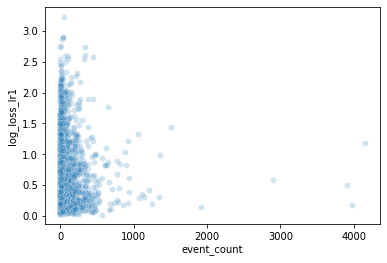

In [179]:
fig,ax = plt.subplots(1,1)
sns.scatterplot(df_X_test.event_count, df_X_test.log_loss_lr1, alpha=0.2)

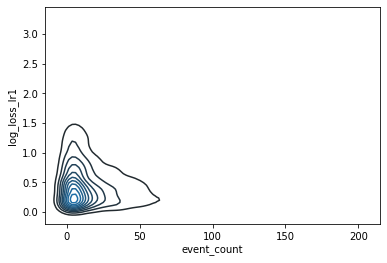

In [180]:
fig,ax = plt.subplots(1,1)
df_X_test_plot = df_X_test[df_X_test.event_count<200]
sns.kdeplot(df_X_test_plot.event_count, df_X_test_plot.log_loss_lr1, )

In [ ]:
# The end